In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

In [2]:
import numba
from numba import njit


In [3]:
from craft import fdmt as FDMT
import sys
sys.path.append("/home/gup037/Codes/ESAM/FDMT_tests/Baraks_FDMT/")
import FDMT as BZ_FDMT

In [290]:
def imshow(x, origin='lower', **kwargs):
    plt.figure(figsize=(6,5))
    plt.imshow(x, aspect='auto', interpolation='None', origin=origin, **kwargs)

In [5]:
@njit(fastmath=True, locals={'val':numba.float32, 'tot_samps_dispersed':numba.int16})
def make_pure_frb(nsamps, nch, tx, dm, fchans, chw_2, tpulse):
    x = np.empty((nch, nsamps), dtype=np.float32)
    fbottom = fchans[0] - chw_2
    ftop = fchans[-1] + chw_2
    
    '''
    max_dm_smear = (fbottom**-2 - (fbottom+chw_2*2)**-2) / (fbottom**-2 - ftop**-2) * dm
    ux_nsamps = int(np.abs(max_dm_smear)) * 4
    ux = np.empty((nch, nsamps), dtype=np.float32)
    ux_loc = ux_nsamps // 2
    '''
    tot_samps_dispersed = 0
    
    for ii in range(nch):
        ftop_i = fchans[ii] + chw_2
        fbottom_i = fchans[ii] - chw_2
        
        cff_until_now = (fbottom**-2 - fbottom_i**-2) / (fbottom**-2 - ftop**-2)
        delta_dm = dm * cff_until_now
        tend = tpulse - delta_dm
        tend_int = int(tend)
        tend_frac = tend - tend_int
        
        
        cff_i = (fbottom_i**-2 - ftop_i**-2) / (fbottom**-2 - ftop**-2)
        dm_i = cff_i * dm
        tstart = tend - dm_i
        tstart_int = int(tstart)
        tstart_frac = 1- (tstart - tstart_int)
        
        fluence = tx
        if tstart_int == tend_int:
            frac_val_tstart = fluence
            full_samps = 0
            
        else:
            full_samps = tend_int - (tstart_int + 1)
            frac_val_tstart = tstart_frac / dm_i * fluence
            frac_val_tend = tend_frac / dm_i * fluence
            full_samp_val = fluence * (1 / dm_i)
        
        for jj in range(nsamps):
            if jj == tstart_int:
                val = frac_val_tstart
                tot_samps_dispersed = tot_samps_dispersed + 1
            elif jj == tend_int:
                val = frac_val_tend
                tot_samps_dispersed = tot_samps_dispersed + 1
            elif (jj > tstart_int) and (jj < tend_int):
                val = full_samp_val
                tot_samps_dispersed = tot_samps_dispersed + 1
            else:
                val = 0
                
            x[ii, jj] = val

        #print(f"chan {ii}, {tstart} {tend}")
        #print(x[ii])
    #x[:, :] = 0
    #x[:, nsamps//2] = 10000
    return x, tot_samps_dispersed

In [6]:
nch = 256
fchans = np.linspace(800.5, 1055.5, nch, endpoint=True, dtype=np.float32)
chw_2 = 0.5
nsamps = 1024
tpulse = 990.1
dm = 2
tx = 10000
x, tot_samps_added = make_pure_frb(nsamps, nch, tx, dm, fchans, chw_2, tpulse)
#%timeit make_pure_frb(nsamps, nch, tx, dm, fchans, chw_2, tpulse)

<IPython.core.display.Javascript object>


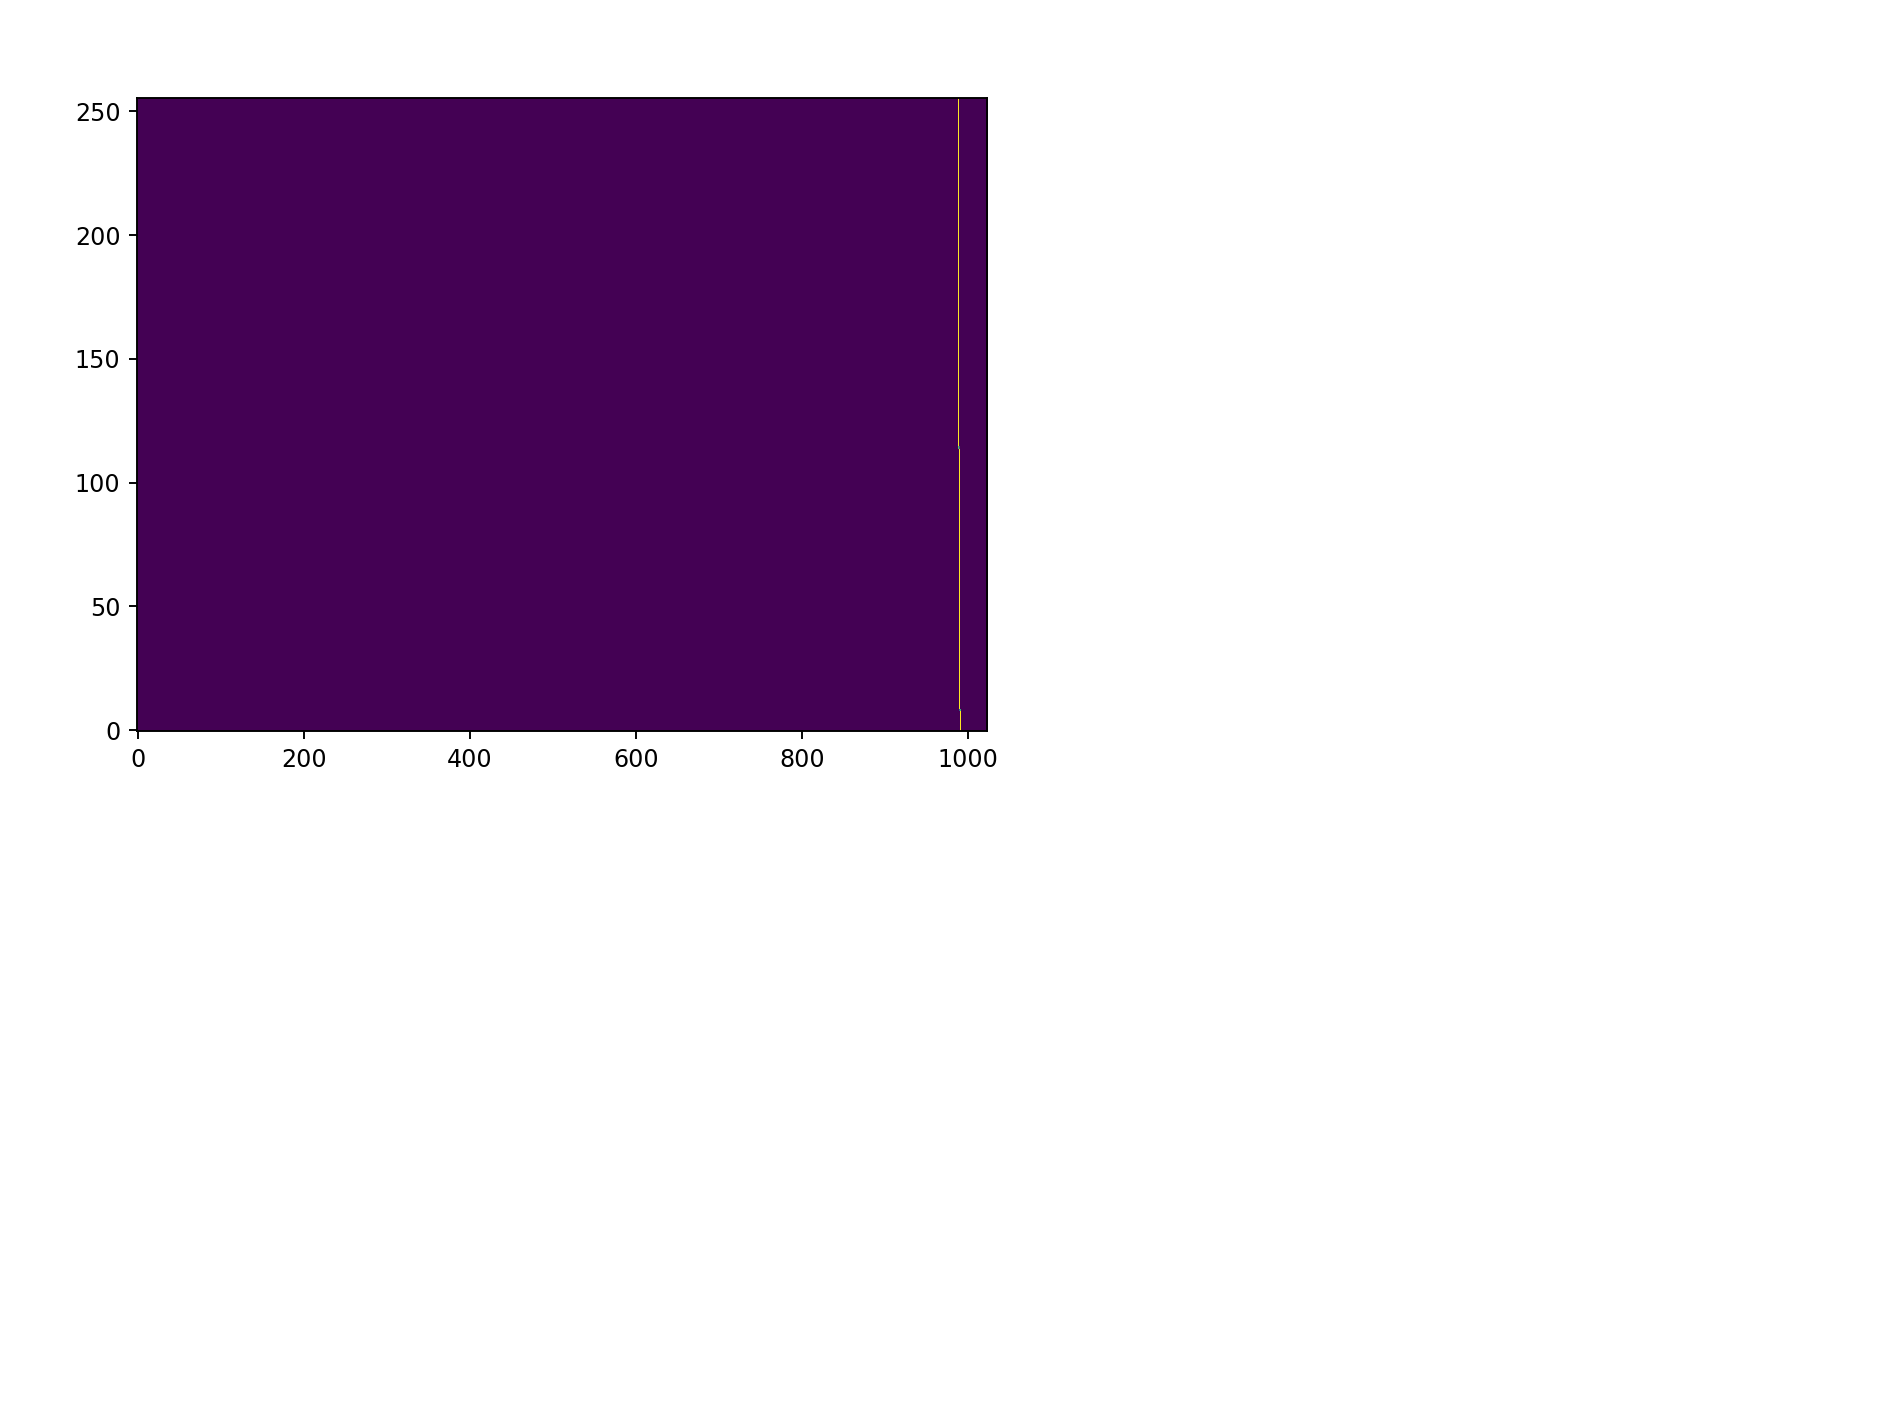

In [7]:
plt.figure()
plt.imshow(x, aspect='auto', interpolation='None', origin='lower')


In [12]:
np.max(x)

10000.0

In [13]:
tot_samps_added / nch

1.0078125

In [14]:
best_possible_snr = x.sum() / np.sqrt(tot_samps_added)

In [15]:
best_possible_snr

159378.63842936073

In [16]:
x.sum() / np.sqrt(256)

160000.0

In [17]:
thefdmt = FDMT.Fdmt(f_min = fchans[0], f_off = chw_2 * 2, n_f = nch, max_dt = 1000, n_t = 1024)

In [18]:
dx = thefdmt(x)

In [19]:
dx.shape

(1000, 2024)

<IPython.core.display.Javascript object>


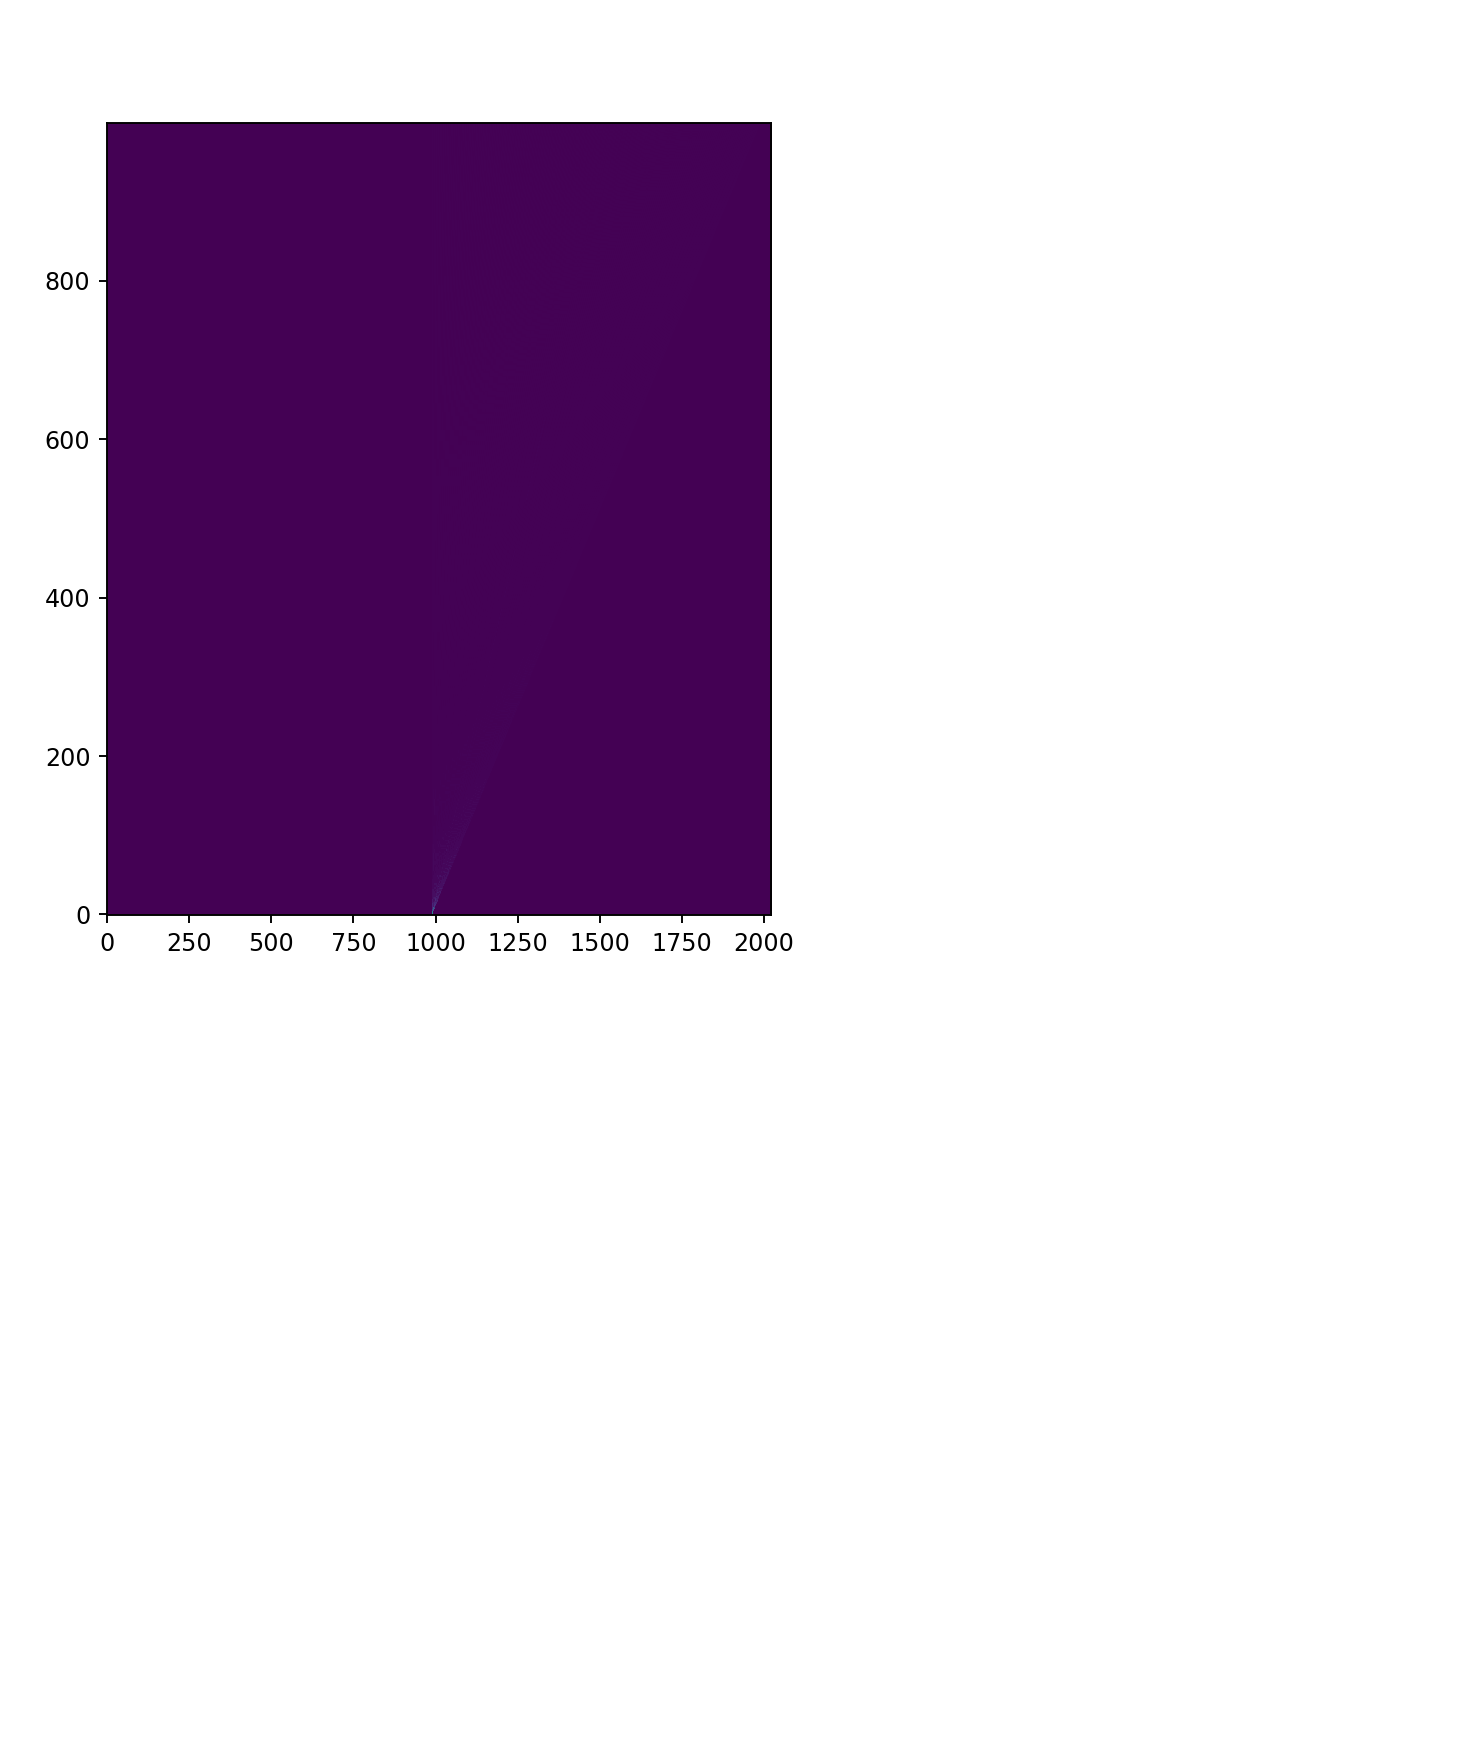

In [20]:
plt.figure(figsize=(5, 6))
plt.imshow(dx, aspect='auto', interpolation='None', origin='lower')

In [21]:
np.max(dx), np.sum(x)

(2189278.0, 2560000.0)

In [22]:
thefdmt.add_frb_track?

In [23]:
track = thefdmt.add_frb_track(2)

<IPython.core.display.Javascript object>


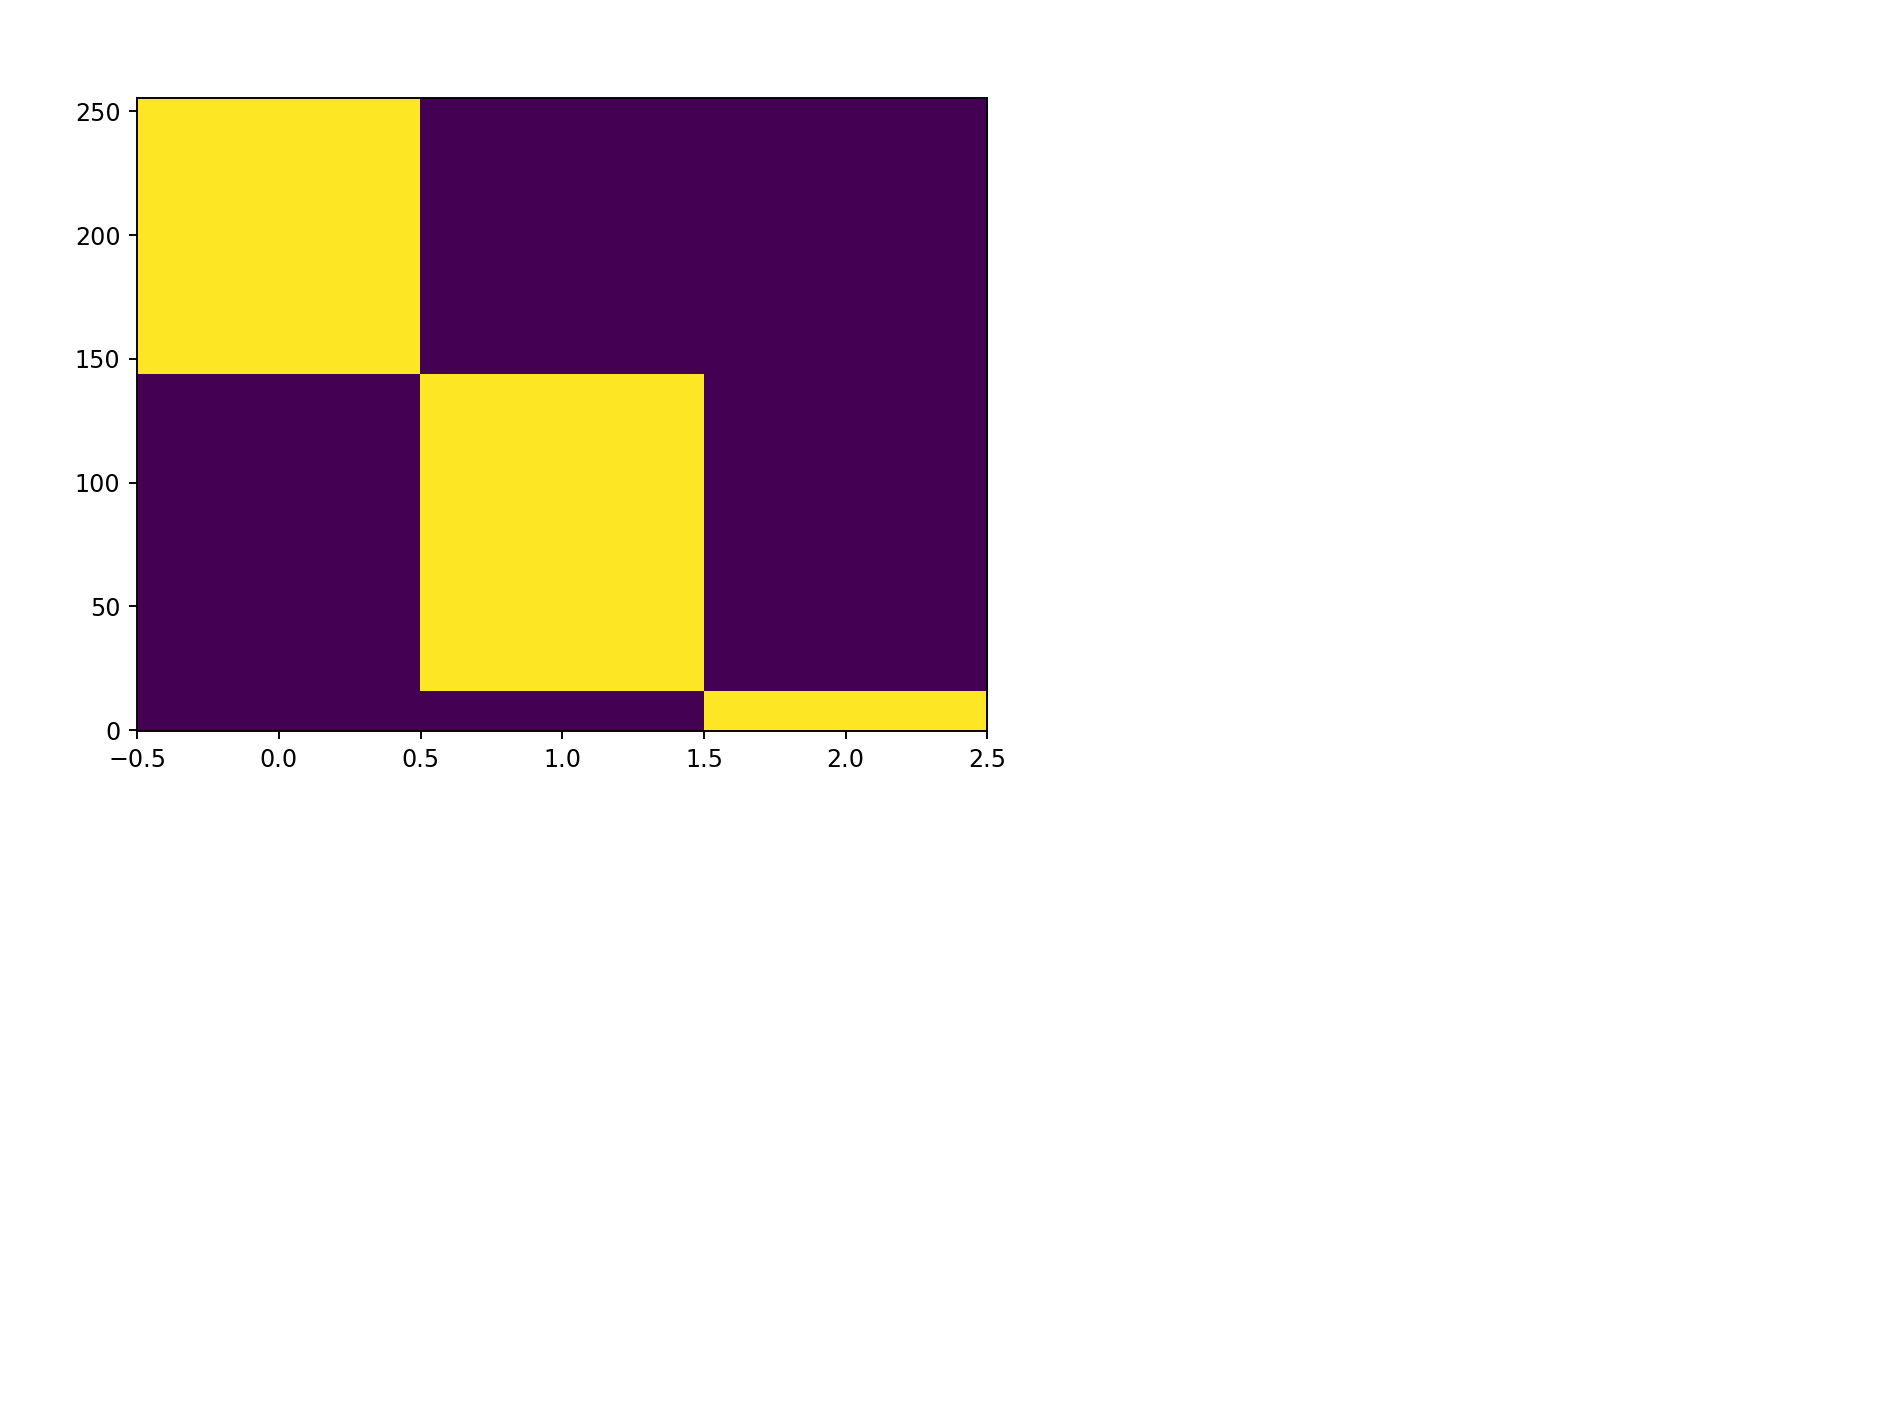

In [24]:
plt.figure()
plt.imshow(track, aspect='auto', interpolation='None', origin='lower')

In [25]:
thefdmt.get_eff_sigma(999, 1)

23.40939982143925

In [37]:
dm_trials = np.arange(0, 1000, 0.1)
nsamps = 1024
nch = 256
tx = 1000
fchans = np.linspace(800.5, 1055.5, nch, endpoint=True, dtype=np.float32)
chw_2 = 0.5
chw = chw_2 * 2
tpulse = 1010.5
max_dm = 1000

thefdmt = FDMT.Fdmt(f_min = fchans[0], f_off = chw_2 * 2, n_f = nch, max_dt = max_dm, n_t = nsamps)

f = open("fdmt_performance_with_bz_spp0.5.txt", 'w')
f.write("DM\tMax_snr\tFDMT_dm\tFDMT_snr\tBZ_FDMT_dm\tBZ_FDMT_snr\n")
ones = np.ones((nch, nsamps), dtype=np.float32)
bz_fdmt_ones = BZ_FDMT.FDMT(ones,  fchans[0] - chw_2, fchans[-1] + chw_2, max_dm, np.float32)
for idm in dm_trials:
    x, tot_samps = make_pure_frb(nsamps, nch, tx, idm, fchans, chw_2, tpulse)
    max_snr = np.sum(x) / np.sqrt(tot_samps)
    
    bz_fdmt = BZ_FDMT.FDMT(x, fchans[0] - chw_2, fchans[-1] + chw_2, max_dm, np.float32)
    bz_fdmt_peak_dm, bz_fdmt_peak_time = np.unravel_index(np.argmax(bz_fdmt), bz_fdmt.shape)
    bz_fdmt_samps_added = bz_fdmt_ones[bz_fdmt_peak_dm, bz_fdmt_peak_time]
    bz_fdmt_snr = np.max(bz_fdmt) / np.sqrt(bz_fdmt_samps_added)
    
    dx = thefdmt(x)
    fdmt_peak_dm, _ = np.unravel_index(np.argmax(dx), dx.shape)
    fdmt_snr = np.max(dx) / thefdmt.get_eff_sigma(fdmt_peak_dm, 1)
    
    out_str = f"{idm:.2f}\t{max_snr:.2f}\t{fdmt_peak_dm}\t{fdmt_snr:.2f}\t{bz_fdmt_peak_dm:.2f}\t{bz_fdmt_snr:.2f}\n"
    f.write(out_str)
    print(idm)
f.close()
    
    

0.0
0.1
0.2
0.30000000000000004
0.4
0.5
0.6000000000000001
0.7000000000000001
0.8
0.9
1.0
1.1
1.2000000000000002
1.3
1.4000000000000001
1.5
1.6
1.7000000000000002
1.8
1.9000000000000001
2.0
2.1
2.2
2.3000000000000003
2.4000000000000004
2.5
2.6
2.7
2.8000000000000003
2.9000000000000004
3.0
3.1
3.2
3.3000000000000003
3.4000000000000004
3.5
3.6
3.7
3.8000000000000003
3.9000000000000004
4.0
4.1000000000000005
4.2
4.3
4.4
4.5
4.6000000000000005
4.7
4.800000000000001
4.9
5.0
5.1000000000000005
5.2
5.300000000000001
5.4
5.5
5.6000000000000005
5.7
5.800000000000001
5.9
6.0
6.1000000000000005
6.2
6.300000000000001
6.4
6.5
6.6000000000000005
6.7
6.800000000000001
6.9
7.0
7.1000000000000005
7.2
7.300000000000001
7.4
7.5
7.6000000000000005
7.7
7.800000000000001
7.9
8.0
8.1
8.200000000000001
8.3
8.4
8.5
8.6
8.700000000000001
8.8
8.9
9.0
9.1
9.200000000000001
9.3
9.4
9.5
9.600000000000001
9.700000000000001
9.8
9.9
10.0
10.100000000000001
10.200000000000001
10.3
10.4
10.5
10.600000000000001
10.700000

84.9
85.0
85.10000000000001
85.2
85.30000000000001
85.4
85.5
85.60000000000001
85.7
85.80000000000001
85.9
86.0
86.10000000000001
86.2
86.30000000000001
86.4
86.5
86.60000000000001
86.7
86.80000000000001
86.9
87.0
87.10000000000001
87.2
87.30000000000001
87.4
87.5
87.60000000000001
87.7
87.80000000000001
87.9
88.0
88.10000000000001
88.2
88.30000000000001
88.4
88.5
88.60000000000001
88.7
88.80000000000001
88.9
89.0
89.10000000000001
89.2
89.30000000000001
89.4
89.5
89.60000000000001
89.7
89.80000000000001
89.9
90.0
90.10000000000001
90.2
90.30000000000001
90.4
90.5
90.60000000000001
90.7
90.80000000000001
90.9
91.0
91.10000000000001
91.2
91.30000000000001
91.4
91.5
91.60000000000001
91.7
91.80000000000001
91.9
92.0
92.10000000000001
92.2
92.30000000000001
92.4
92.5
92.60000000000001
92.7
92.80000000000001
92.9
93.0
93.10000000000001
93.2
93.30000000000001
93.4
93.5
93.60000000000001
93.7
93.80000000000001
93.9
94.0
94.10000000000001
94.2
94.30000000000001
94.4
94.5
94.60000000000001
94.

165.3
165.4
165.5
165.60000000000002
165.70000000000002
165.8
165.9
166.0
166.10000000000002
166.20000000000002
166.3
166.4
166.5
166.60000000000002
166.70000000000002
166.8
166.9
167.0
167.10000000000002
167.20000000000002
167.3
167.4
167.5
167.60000000000002
167.70000000000002
167.8
167.9
168.0
168.10000000000002
168.20000000000002
168.3
168.4
168.5
168.60000000000002
168.70000000000002
168.8
168.9
169.0
169.10000000000002
169.20000000000002
169.3
169.4
169.5
169.60000000000002
169.70000000000002
169.8
169.9
170.0
170.10000000000002
170.20000000000002
170.3
170.4
170.5
170.60000000000002
170.70000000000002
170.8
170.9
171.0
171.10000000000002
171.20000000000002
171.3
171.4
171.5
171.60000000000002
171.70000000000002
171.8
171.9
172.0
172.10000000000002
172.20000000000002
172.3
172.4
172.5
172.60000000000002
172.70000000000002
172.8
172.9
173.0
173.10000000000002
173.20000000000002
173.3
173.4
173.5
173.60000000000002
173.70000000000002
173.8
173.9
174.0
174.10000000000002
174.2000000

238.60000000000002
238.70000000000002
238.8
238.9
239.0
239.10000000000002
239.20000000000002
239.3
239.4
239.5
239.60000000000002
239.70000000000002
239.8
239.9
240.0
240.10000000000002
240.20000000000002
240.3
240.4
240.5
240.60000000000002
240.70000000000002
240.8
240.9
241.0
241.10000000000002
241.20000000000002
241.3
241.4
241.5
241.60000000000002
241.70000000000002
241.8
241.9
242.0
242.10000000000002
242.20000000000002
242.3
242.4
242.5
242.60000000000002
242.70000000000002
242.8
242.9
243.0
243.10000000000002
243.20000000000002
243.3
243.4
243.5
243.60000000000002
243.70000000000002
243.8
243.9
244.0
244.10000000000002
244.20000000000002
244.3
244.4
244.5
244.60000000000002
244.70000000000002
244.8
244.9
245.0
245.10000000000002
245.20000000000002
245.3
245.4
245.5
245.60000000000002
245.70000000000002
245.8
245.9
246.0
246.10000000000002
246.20000000000002
246.3
246.4
246.5
246.60000000000002
246.70000000000002
246.8
246.9
247.0
247.10000000000002
247.20000000000002
247.3
247.

323.6
323.70000000000005
323.8
323.90000000000003
324.0
324.1
324.20000000000005
324.3
324.40000000000003
324.5
324.6
324.70000000000005
324.8
324.90000000000003
325.0
325.1
325.20000000000005
325.3
325.40000000000003
325.5
325.6
325.70000000000005
325.8
325.90000000000003
326.0
326.1
326.20000000000005
326.3
326.40000000000003
326.5
326.6
326.70000000000005
326.8
326.90000000000003
327.0
327.1
327.20000000000005
327.3
327.40000000000003
327.5
327.6
327.70000000000005
327.8
327.90000000000003
328.0
328.1
328.20000000000005
328.3
328.40000000000003
328.5
328.6
328.70000000000005
328.8
328.90000000000003
329.0
329.1
329.20000000000005
329.3
329.40000000000003
329.5
329.6
329.70000000000005
329.8
329.90000000000003
330.0
330.1
330.20000000000005
330.3
330.40000000000003
330.5
330.6
330.70000000000005
330.8
330.90000000000003
331.0
331.1
331.20000000000005
331.3
331.40000000000003
331.5
331.6
331.70000000000005
331.8
331.90000000000003
332.0
332.1
332.20000000000005
332.3
332.4000000000000

396.8
396.90000000000003
397.0
397.1
397.20000000000005
397.3
397.40000000000003
397.5
397.6
397.70000000000005
397.8
397.90000000000003
398.0
398.1
398.20000000000005
398.3
398.40000000000003
398.5
398.6
398.70000000000005
398.8
398.90000000000003
399.0
399.1
399.20000000000005
399.3
399.40000000000003
399.5
399.6
399.70000000000005
399.8
399.90000000000003
400.0
400.1
400.20000000000005
400.3
400.40000000000003
400.5
400.6
400.70000000000005
400.8
400.90000000000003
401.0
401.1
401.20000000000005
401.3
401.40000000000003
401.5
401.6
401.70000000000005
401.8
401.90000000000003
402.0
402.1
402.20000000000005
402.3
402.40000000000003
402.5
402.6
402.70000000000005
402.8
402.90000000000003
403.0
403.1
403.20000000000005
403.3
403.40000000000003
403.5
403.6
403.70000000000005
403.8
403.90000000000003
404.0
404.1
404.20000000000005
404.3
404.40000000000003
404.5
404.6
404.70000000000005
404.8
404.90000000000003
405.0
405.1
405.20000000000005
405.3
405.40000000000003
405.5
405.6
405.7000000

470.0
470.1
470.20000000000005
470.3
470.40000000000003
470.5
470.6
470.70000000000005
470.8
470.90000000000003
471.0
471.1
471.20000000000005
471.3
471.40000000000003
471.5
471.6
471.70000000000005
471.8
471.90000000000003
472.0
472.1
472.20000000000005
472.3
472.40000000000003
472.5
472.6
472.70000000000005
472.8
472.90000000000003
473.0
473.1
473.20000000000005
473.3
473.40000000000003
473.5
473.6
473.70000000000005
473.8
473.90000000000003
474.0
474.1
474.20000000000005
474.3
474.40000000000003
474.5
474.6
474.70000000000005
474.8
474.90000000000003
475.0
475.1
475.20000000000005
475.3
475.40000000000003
475.5
475.6
475.70000000000005
475.8
475.90000000000003
476.0
476.1
476.20000000000005
476.3
476.40000000000003
476.5
476.6
476.70000000000005
476.8
476.90000000000003
477.0
477.1
477.20000000000005
477.3
477.40000000000003
477.5
477.6
477.70000000000005
477.8
477.90000000000003
478.0
478.1
478.20000000000005
478.3
478.40000000000003
478.5
478.6
478.70000000000005
478.8
478.9000000

553.6
553.7
553.8000000000001
553.9
554.0
554.1
554.2
554.3000000000001
554.4
554.5
554.6
554.7
554.8000000000001
554.9
555.0
555.1
555.2
555.3000000000001
555.4
555.5
555.6
555.7
555.8000000000001
555.9
556.0
556.1
556.2
556.3000000000001
556.4
556.5
556.6
556.7
556.8000000000001
556.9
557.0
557.1
557.2
557.3000000000001
557.4
557.5
557.6
557.7
557.8000000000001
557.9
558.0
558.1
558.2
558.3000000000001
558.4
558.5
558.6
558.7
558.8000000000001
558.9
559.0
559.1
559.2
559.3000000000001
559.4
559.5
559.6
559.7
559.8000000000001
559.9
560.0
560.1
560.2
560.3000000000001
560.4
560.5
560.6
560.7
560.8000000000001
560.9
561.0
561.1
561.2
561.3000000000001
561.4
561.5
561.6
561.7
561.8000000000001
561.9
562.0
562.1
562.2
562.3000000000001
562.4
562.5
562.6
562.7
562.8000000000001
562.9
563.0
563.1
563.2
563.3000000000001
563.4
563.5
563.6
563.7
563.8000000000001
563.9
564.0
564.1
564.2
564.3000000000001
564.4
564.5
564.6
564.7
564.8000000000001
564.9
565.0
565.1
565.2
565.3000000000001
565.

643.0
643.1
643.2
643.3000000000001
643.4000000000001
643.5
643.6
643.7
643.8000000000001
643.9000000000001
644.0
644.1
644.2
644.3000000000001
644.4000000000001
644.5
644.6
644.7
644.8000000000001
644.9000000000001
645.0
645.1
645.2
645.3000000000001
645.4000000000001
645.5
645.6
645.7
645.8000000000001
645.9000000000001
646.0
646.1
646.2
646.3000000000001
646.4000000000001
646.5
646.6
646.7
646.8000000000001
646.9000000000001
647.0
647.1
647.2
647.3000000000001
647.4000000000001
647.5
647.6
647.7
647.8000000000001
647.9000000000001
648.0
648.1
648.2
648.3000000000001
648.4000000000001
648.5
648.6
648.7
648.8000000000001
648.9000000000001
649.0
649.1
649.2
649.3000000000001
649.4000000000001
649.5
649.6
649.7
649.8000000000001
649.9000000000001
650.0
650.1
650.2
650.3000000000001
650.4000000000001
650.5
650.6
650.7
650.8000000000001
650.9000000000001
651.0
651.1
651.2
651.3000000000001
651.4000000000001
651.5
651.6
651.7
651.8000000000001
651.9000000000001
652.0
652.1
652.2
652.300000

719.0
719.1
719.2
719.3000000000001
719.4000000000001
719.5
719.6
719.7
719.8000000000001
719.9000000000001
720.0
720.1
720.2
720.3000000000001
720.4000000000001
720.5
720.6
720.7
720.8000000000001
720.9000000000001
721.0
721.1
721.2
721.3000000000001
721.4000000000001
721.5
721.6
721.7
721.8000000000001
721.9000000000001
722.0
722.1
722.2
722.3000000000001
722.4000000000001
722.5
722.6
722.7
722.8000000000001
722.9000000000001
723.0
723.1
723.2
723.3000000000001
723.4000000000001
723.5
723.6
723.7
723.8000000000001
723.9000000000001
724.0
724.1
724.2
724.3000000000001
724.4000000000001
724.5
724.6
724.7
724.8000000000001
724.9000000000001
725.0
725.1
725.2
725.3000000000001
725.4000000000001
725.5
725.6
725.7
725.8000000000001
725.9000000000001
726.0
726.1
726.2
726.3000000000001
726.4000000000001
726.5
726.6
726.7
726.8000000000001
726.9000000000001
727.0
727.1
727.2
727.3000000000001
727.4000000000001
727.5
727.6
727.7
727.8000000000001
727.9000000000001
728.0
728.1
728.2
728.300000

795.0
795.1
795.2
795.3000000000001
795.4000000000001
795.5
795.6
795.7
795.8000000000001
795.9000000000001
796.0
796.1
796.2
796.3000000000001
796.4000000000001
796.5
796.6
796.7
796.8000000000001
796.9000000000001
797.0
797.1
797.2
797.3000000000001
797.4000000000001
797.5
797.6
797.7
797.8000000000001
797.9000000000001
798.0
798.1
798.2
798.3000000000001
798.4000000000001
798.5
798.6
798.7
798.8000000000001
798.9000000000001
799.0
799.1
799.2
799.3000000000001
799.4000000000001
799.5
799.6
799.7
799.8000000000001
799.9000000000001
800.0
800.1
800.2
800.3000000000001
800.4000000000001
800.5
800.6
800.7
800.8000000000001
800.9000000000001
801.0
801.1
801.2
801.3000000000001
801.4000000000001
801.5
801.6
801.7
801.8000000000001
801.9000000000001
802.0
802.1
802.2
802.3000000000001
802.4000000000001
802.5
802.6
802.7
802.8000000000001
802.9000000000001
803.0
803.1
803.2
803.3000000000001
803.4000000000001
803.5
803.6
803.7
803.8000000000001
803.9000000000001
804.0
804.1
804.2
804.300000

871.0
871.1
871.2
871.3000000000001
871.4000000000001
871.5
871.6
871.7
871.8000000000001
871.9000000000001
872.0
872.1
872.2
872.3000000000001
872.4000000000001
872.5
872.6
872.7
872.8000000000001
872.9000000000001
873.0
873.1
873.2
873.3000000000001
873.4000000000001
873.5
873.6
873.7
873.8000000000001
873.9000000000001
874.0
874.1
874.2
874.3000000000001
874.4000000000001
874.5
874.6
874.7
874.8000000000001
874.9000000000001
875.0
875.1
875.2
875.3000000000001
875.4000000000001
875.5
875.6
875.7
875.8000000000001
875.9000000000001
876.0
876.1
876.2
876.3000000000001
876.4000000000001
876.5
876.6
876.7
876.8000000000001
876.9000000000001
877.0
877.1
877.2
877.3000000000001
877.4000000000001
877.5
877.6
877.7
877.8000000000001
877.9000000000001
878.0
878.1
878.2
878.3000000000001
878.4000000000001
878.5
878.6
878.7
878.8000000000001
878.9000000000001
879.0
879.1
879.2
879.3000000000001
879.4000000000001
879.5
879.6
879.7
879.8000000000001
879.9000000000001
880.0
880.1
880.2
880.300000

947.0
947.1
947.2
947.3000000000001
947.4000000000001
947.5
947.6
947.7
947.8000000000001
947.9000000000001
948.0
948.1
948.2
948.3000000000001
948.4000000000001
948.5
948.6
948.7
948.8000000000001
948.9000000000001
949.0
949.1
949.2
949.3000000000001
949.4000000000001
949.5
949.6
949.7
949.8000000000001
949.9000000000001
950.0
950.1
950.2
950.3000000000001
950.4000000000001
950.5
950.6
950.7
950.8000000000001
950.9000000000001
951.0
951.1
951.2
951.3000000000001
951.4000000000001
951.5
951.6
951.7
951.8000000000001
951.9000000000001
952.0
952.1
952.2
952.3000000000001
952.4000000000001
952.5
952.6
952.7
952.8000000000001
952.9000000000001
953.0
953.1
953.2
953.3000000000001
953.4000000000001
953.5
953.6
953.7
953.8000000000001
953.9000000000001
954.0
954.1
954.2
954.3000000000001
954.4000000000001
954.5
954.6
954.7
954.8000000000001
954.9000000000001
955.0
955.1
955.2
955.3000000000001
955.4000000000001
955.5
955.6
955.7
955.8000000000001
955.9000000000001
956.0
956.1
956.2
956.300000

In [27]:
f.close()

In [38]:
import pandas as pd
stats5 = pd.read_csv("fdmt_performance_with_bz_spp0.5.txt", sep='\s+')
stats1 = pd.read_csv("fdmt_performance_with_bz_spp0.1.txt", sep='\s+')

In [46]:
peak5=stats5['Max_snr']
peak1 = stats1['Max_snr']

In [47]:
peak1, peak5

(0       16000.00
 1       16000.00
 2       15968.84
 3       15968.84
 4       15968.84
           ...   
 9995     7223.46
 9996     7223.46
 9997     7223.46
 9998     7223.46
 9999     7223.46
 Name: Max_snr, Length: 10000, dtype: float64,
 0       16000.00
 1       16000.00
 2       16000.00
 3       16000.00
 4       16000.00
           ...   
 9995     7223.46
 9996     7223.46
 9997     7223.46
 9998     7223.46
 9999     7223.46
 Name: Max_snr, Length: 10000, dtype: float64)

<IPython.core.display.Javascript object>


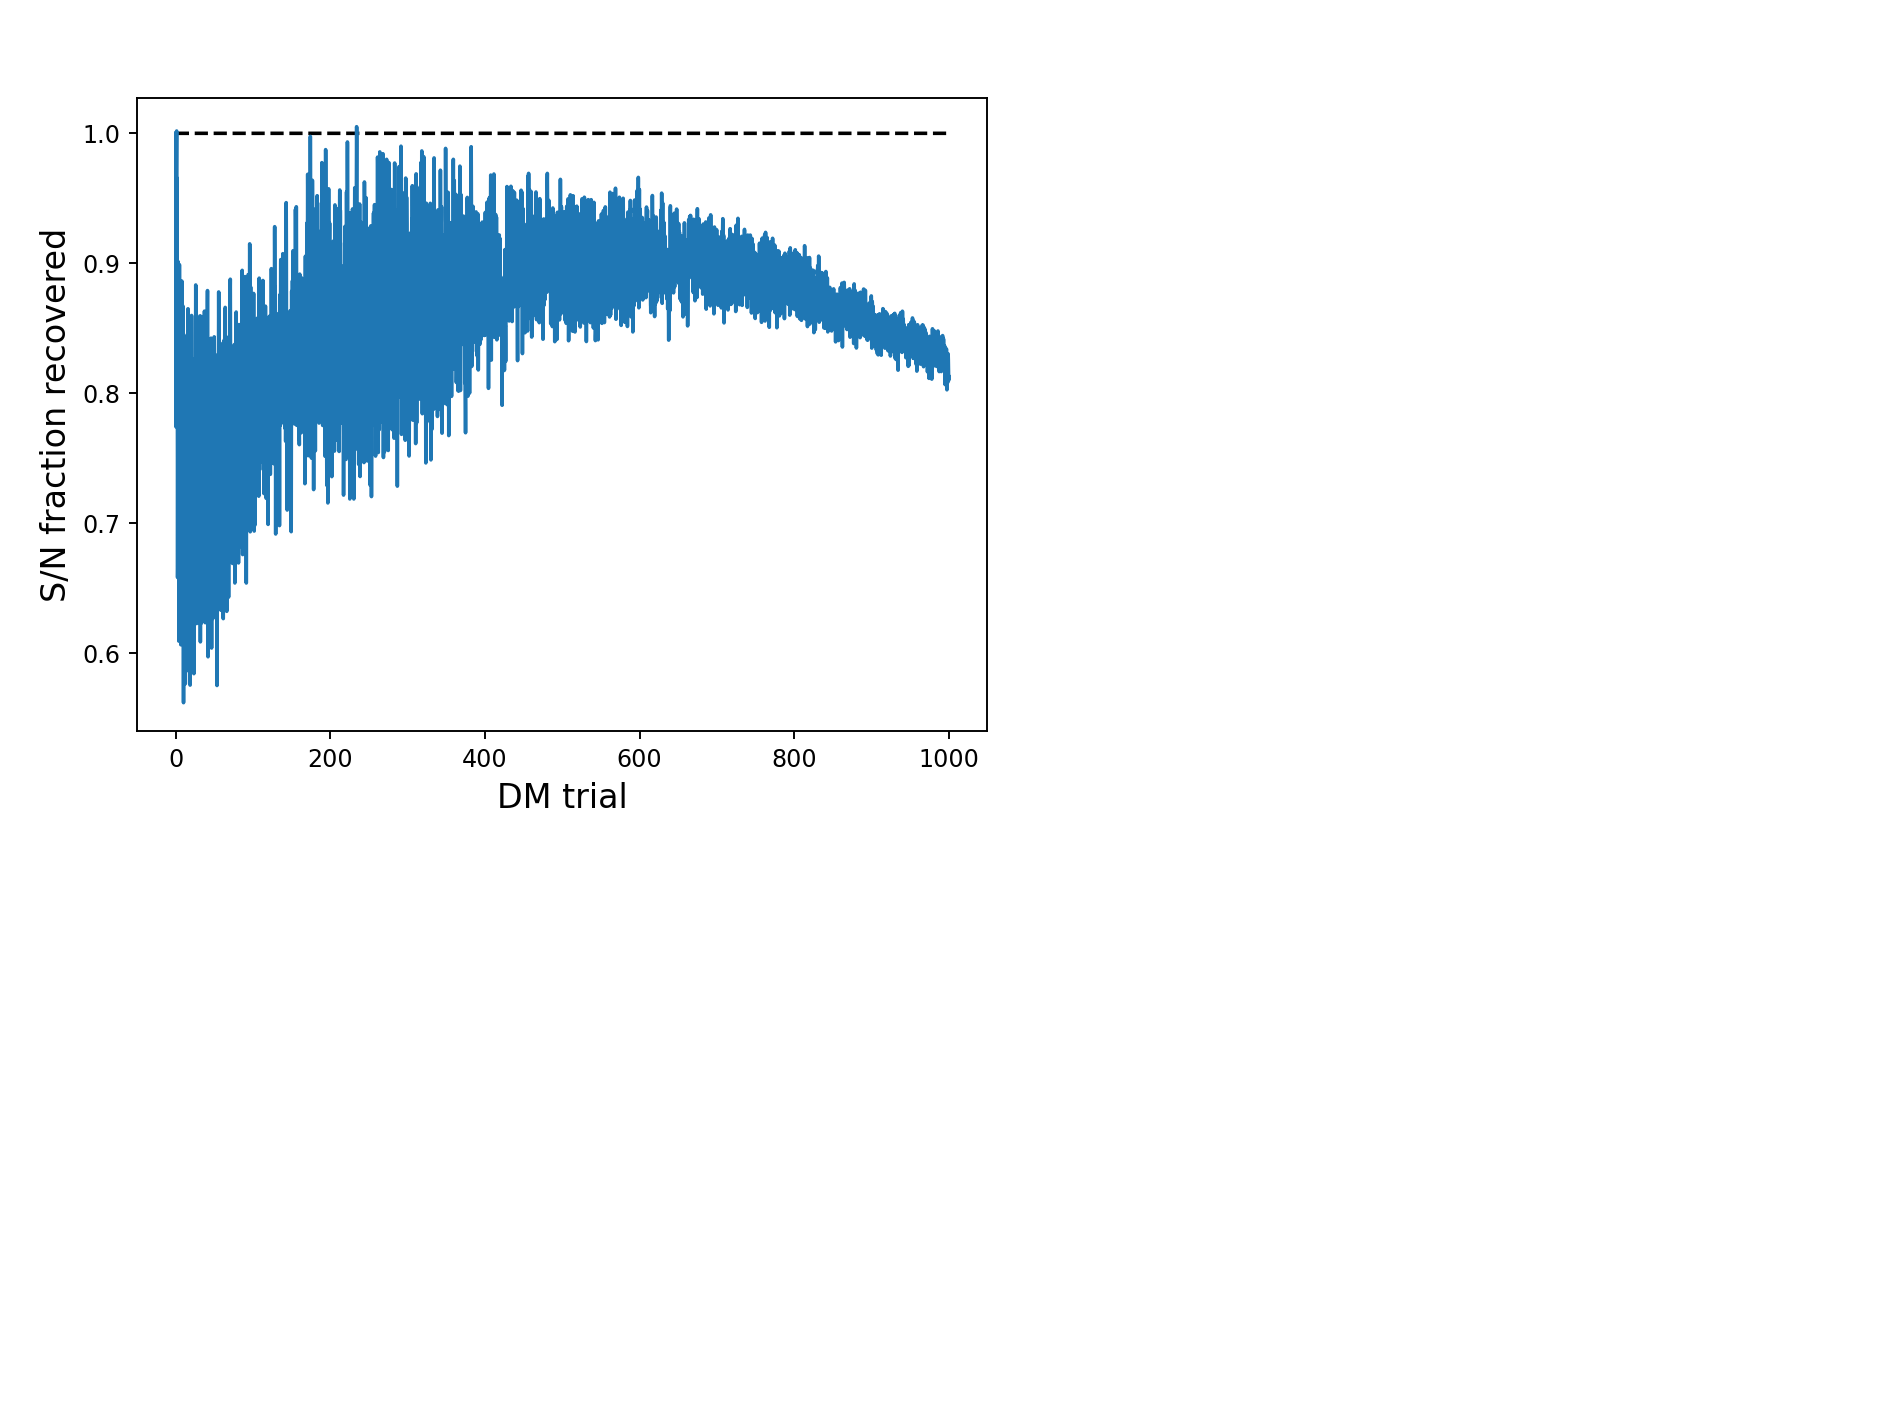

Text(0.5, 0, 'DM trial')

In [325]:
plt.figure()
plt.plot(stats5['DM'],np.ones_like(stats5['DM']), 'k--')
#plt.plot(stats5['DM'], stats5['BZ_FDMT_snr']/peak5)
#plt.plot(stats5['DM'], stats5['BZ_FDMT_snr']/peak5)

plt.plot(stats1['DM'], stats1['BZ_FDMT_snr']/peak1)
#plt.plot(stats1['DM'], stats1['FDMT_snr']/peak1)

#plt.plot(stats1['BZ_FDMT_dm'], stats1['BZ_FDMT_snr'] / stats1['BZ_FDMT_snr'].iloc[0])
plt.ylabel("S/N fraction recovered", fontsize = 14)

plt.xlabel("DM trial", fontsize = 14)

# Trying to understand why is there a decline in the performance of the FDMT at high DMs

In [213]:
x600, tot_samps600 = make_pure_frb(nsamps, nch, tx, 600, fchans, chw_2, 1000)
x950, tot_samps950 = make_pure_frb(nsamps, nch, tx, 950, fchans, chw_2, 1000)
    

<IPython.core.display.Javascript object>


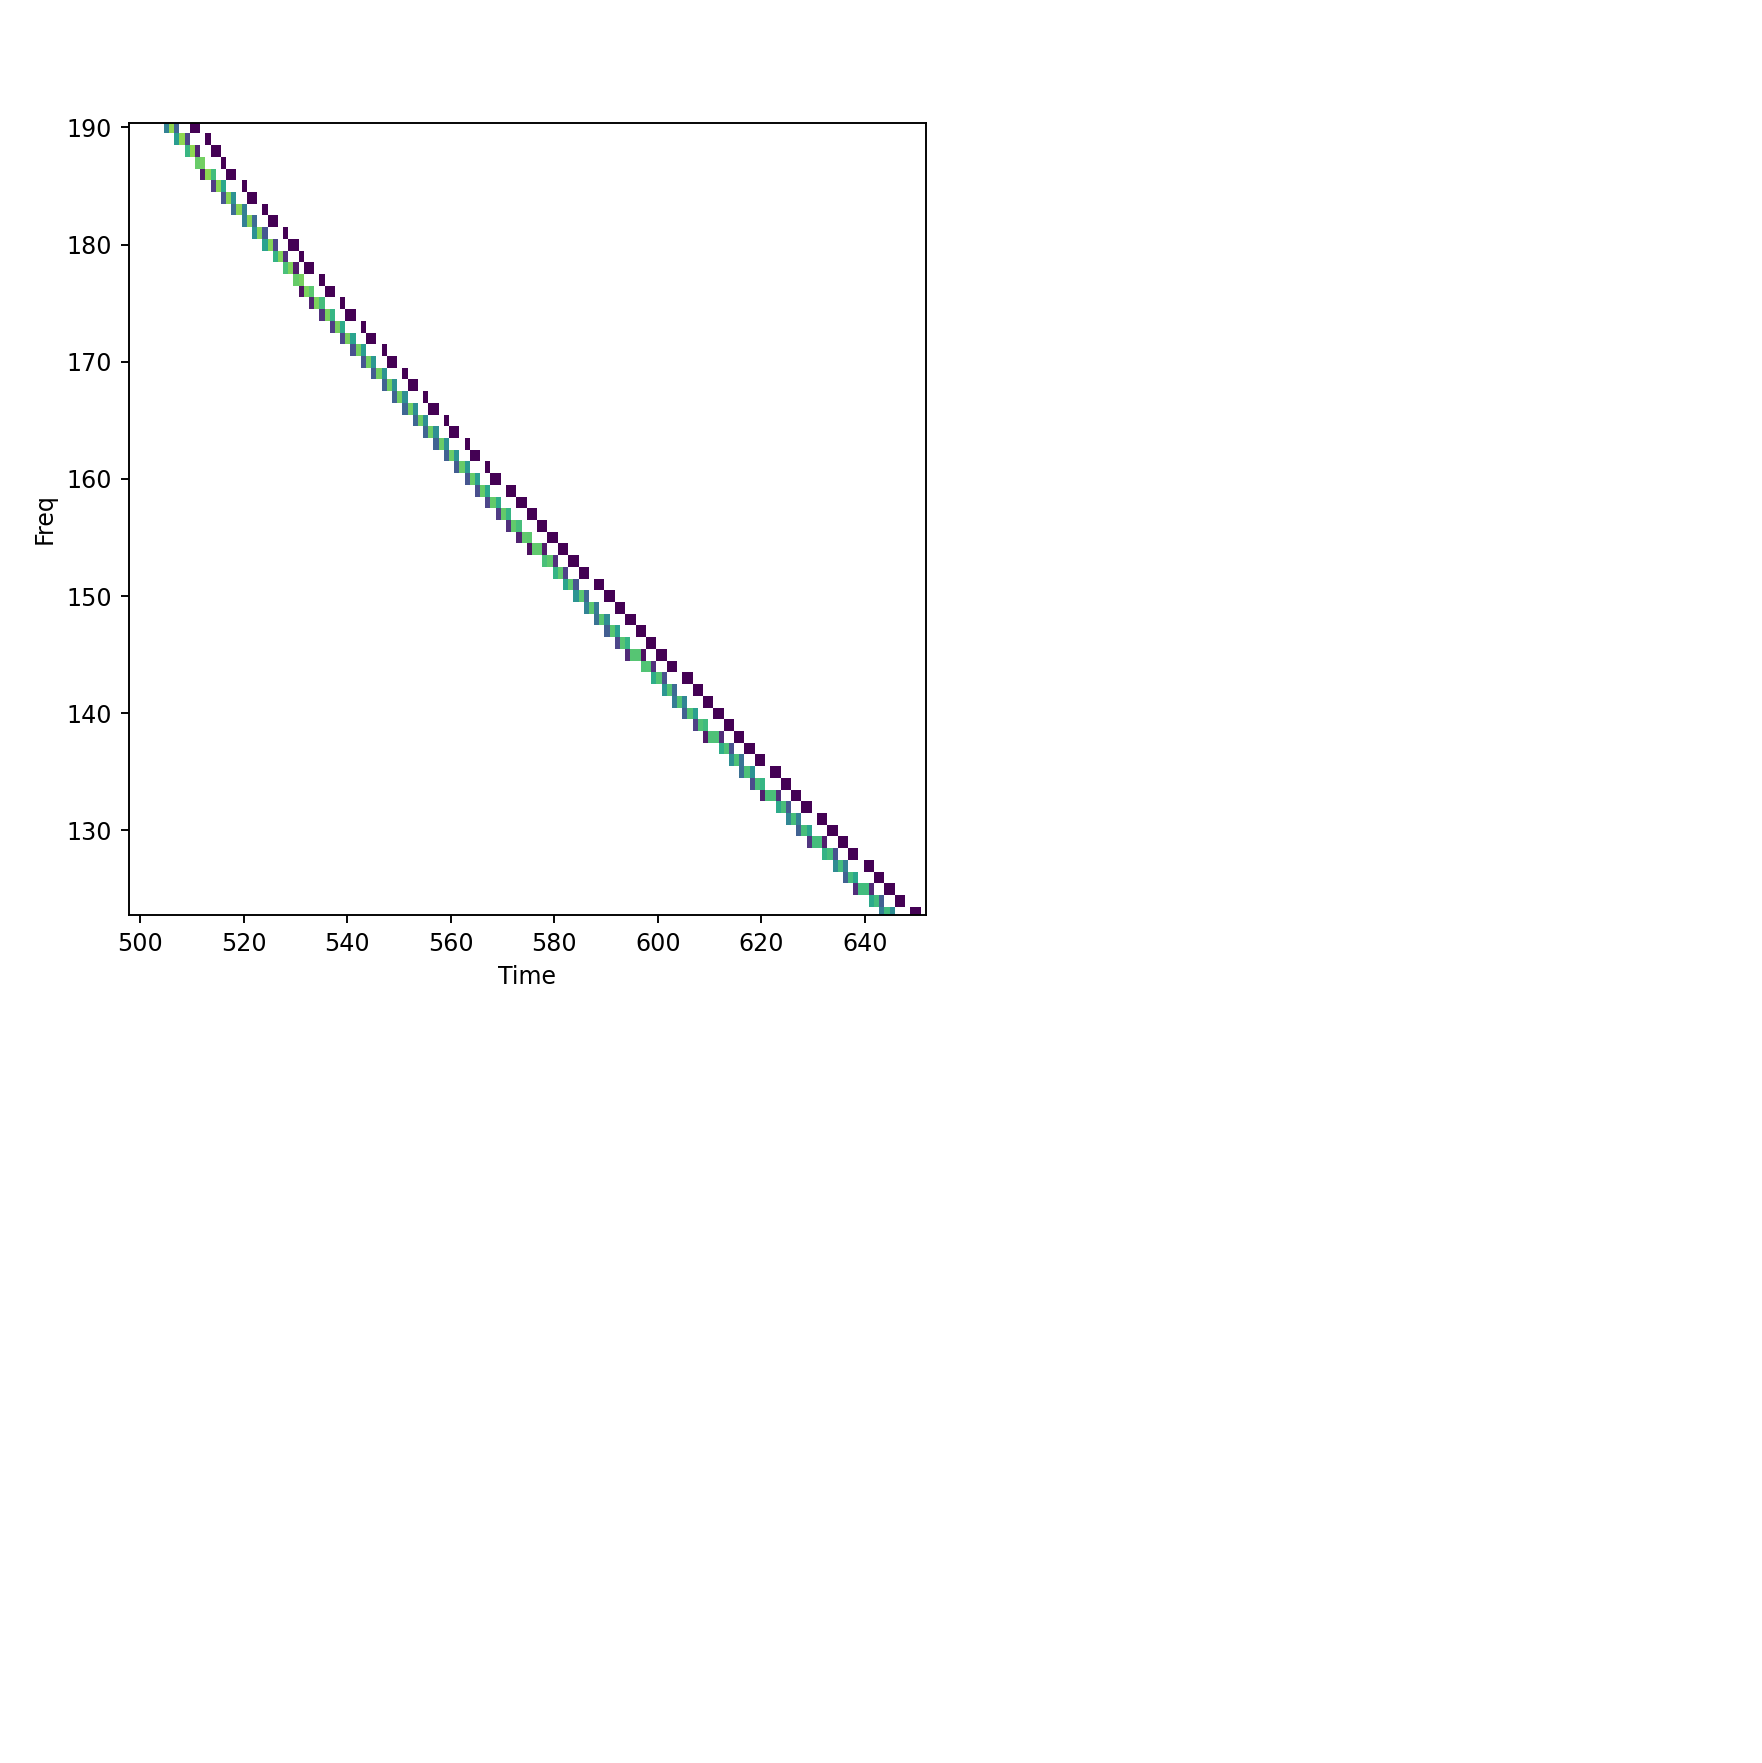

Text(0, 0.5, 'Freq')

In [250]:
fdmt_mask600 = thefdmt.add_frb_track(600, np.zeros((nch, nsamps)), toffset=401)
fdmt_mask950 = thefdmt.add_frb_track(950, np.zeros((nch, nsamps)), toffset=51)

fdmt_mask_temp = fdmt_mask600.copy()
fdmt_mask_temp[fdmt_mask_temp == 0] = np.nan
x600_temp   = x600.copy()
x600_temp[x600_temp == 0] = np.nan

imshow(fdmt_mask_temp, alpha=1)
#plt.figure(figsize=(5, 6))
plt.imshow(np.roll(x600_temp, -5, axis=1), aspect='auto', interpolation='None', alpha=0.95, origin='lower')

plt.xlabel("Time")
plt.ylabel("Freq")

In [230]:
np.sum(x600 * fdmt_mask600 ) / np.sqrt(tot_samps600), np.sum(np.roll(x950, 0, axis=1) * fdmt_mask950) / np.sqrt(tot_samps950)

(530.9658732208799, 366.32406903699825)

In [42]:
import sys
sys.path.append("/home/gup037/Codes/ESAM/esam")
import traces

In [96]:
track= traces.get_fdmt_track(1000, fchans[0], chw_2*2, nch)
ts, fs = traces.get_dm_curve(1000, fchans[0], chw_2*2, nch)

800.0 1056.0
          + 256 0 1000 1000.5
          + 256 0 1000 1000.5 397.2077575956372 602.7922424043628
          + 128 0 602.7922424043628 1000.5
          + 128 0 602.7922424043628 1000.5 267.96891332815994 334.82332907620287
          + 64 0 334.82332907620287 1000.5
          + 64 0 334.82332907620287 1000.5 157.75806178381342 177.06526729238945
          + 32 0 177.06526729238945 1000.5
          + 32 0 177.06526729238945 1000.5 85.92906636171288 91.13620093067657
          + 16 0 91.13620093067657 1000.5
          + 16 0 91.13620093067657 1000.5 44.89136861200572 46.244832318670845
          + 8 0 46.244832318670845 1000.5
          + 8 0 46.244832318670845 1000.5 22.949862238551532 23.294970080119313
          + 4 0 23.294970080119313 1000.5
          + 4 0 23.294970080119313 1000.5 11.603915984341516 11.6910540957778
          + 2 0 11.6910540957778 1000.5
          + 2 0 11.6910540957778 1000.5 5.834580373710928 5.856473722066872
[0.34942914941363157, 0.3251139090627127, 

~ 104 4.0597044777617315 491.54900472858554 491 4
[0.37704664011968425, 0.341549363592471, 0.3756102763050257, 0.4280611930996985] 1
~ 105 4.046269167795033 487.4893002508238 487 4
          + 2 53 8.052468955642865 483.44303108302876
          + 2 53 8.052468955642865 483.44303108302876 4.019575878847219 4.032893076795647
[0.37906281978713396, 0.34258501905990285, 0.37597529411767056, 0.4294809643069171] 1
~ 106 4.032893076795647 483.44303108302876 483 4
[0.3807959730600057, 0.3436374435764473, 0.37664492891131396, 0.4309038713969049] 1
~ 107 4.019575878847219 479.4101380062331 479 4
          + 4 27 15.946298109810353 475.3905621273859
          + 4 27 15.946298109810353 475.3905621273859 7.946863990452626 7.999434119357726
          + 2 54 7.999434119357726 475.3905621273859
          + 2 54 7.999434119357726 475.3905621273859 3.9931168691738232 4.006317250183903
[0.38221392841314145, 0.3446312753186011, 0.377568240486629, 0.43232991782899344] 1
~ 108 4.006317250183903 475.390562127

[0.4226221684616011, 0.3829126361550864, 0.4414104342828495, 0.5166573616033785] 1
~ 231 2.7372368371647053 66.61609027145352 66 3
          + 8 29 21.614417604866237 63.8788534342888
          + 8 29 21.614417604866237 63.8788534342888 10.744619101080849 10.869798503785388
          + 4 58 10.869798503785388 63.8788534342888
          + 4 58 10.869798503785388 63.8788534342888 5.419130705062737 5.450667798722652
          + 2 116 5.450667798722652 63.8788534342888
          + 2 116 5.450667798722652 63.8788534342888 2.721376494160867 2.729291304561784
[0.3401015178071048, 0.33417918829793825, 0.34491647775601786, 0.36639548088127605] 1
~ 232 2.729291304561784 63.8788534342888 63 2
[0.44130898439395266, 0.38317139441110704, 0.42549228385052035, 0.5196684712341382] 1
~ 233 2.721376494160867 61.149562129727016 61 3
          + 2 117 5.419130705062737 58.42818563556615
          + 2 117 5.419130705062737 58.42818563556615 2.7056384474453012 2.713492257617436
[0.4298484439889692, 0.3805290

In [97]:
track.shape

(256, 1001)

<IPython.core.display.Javascript object>


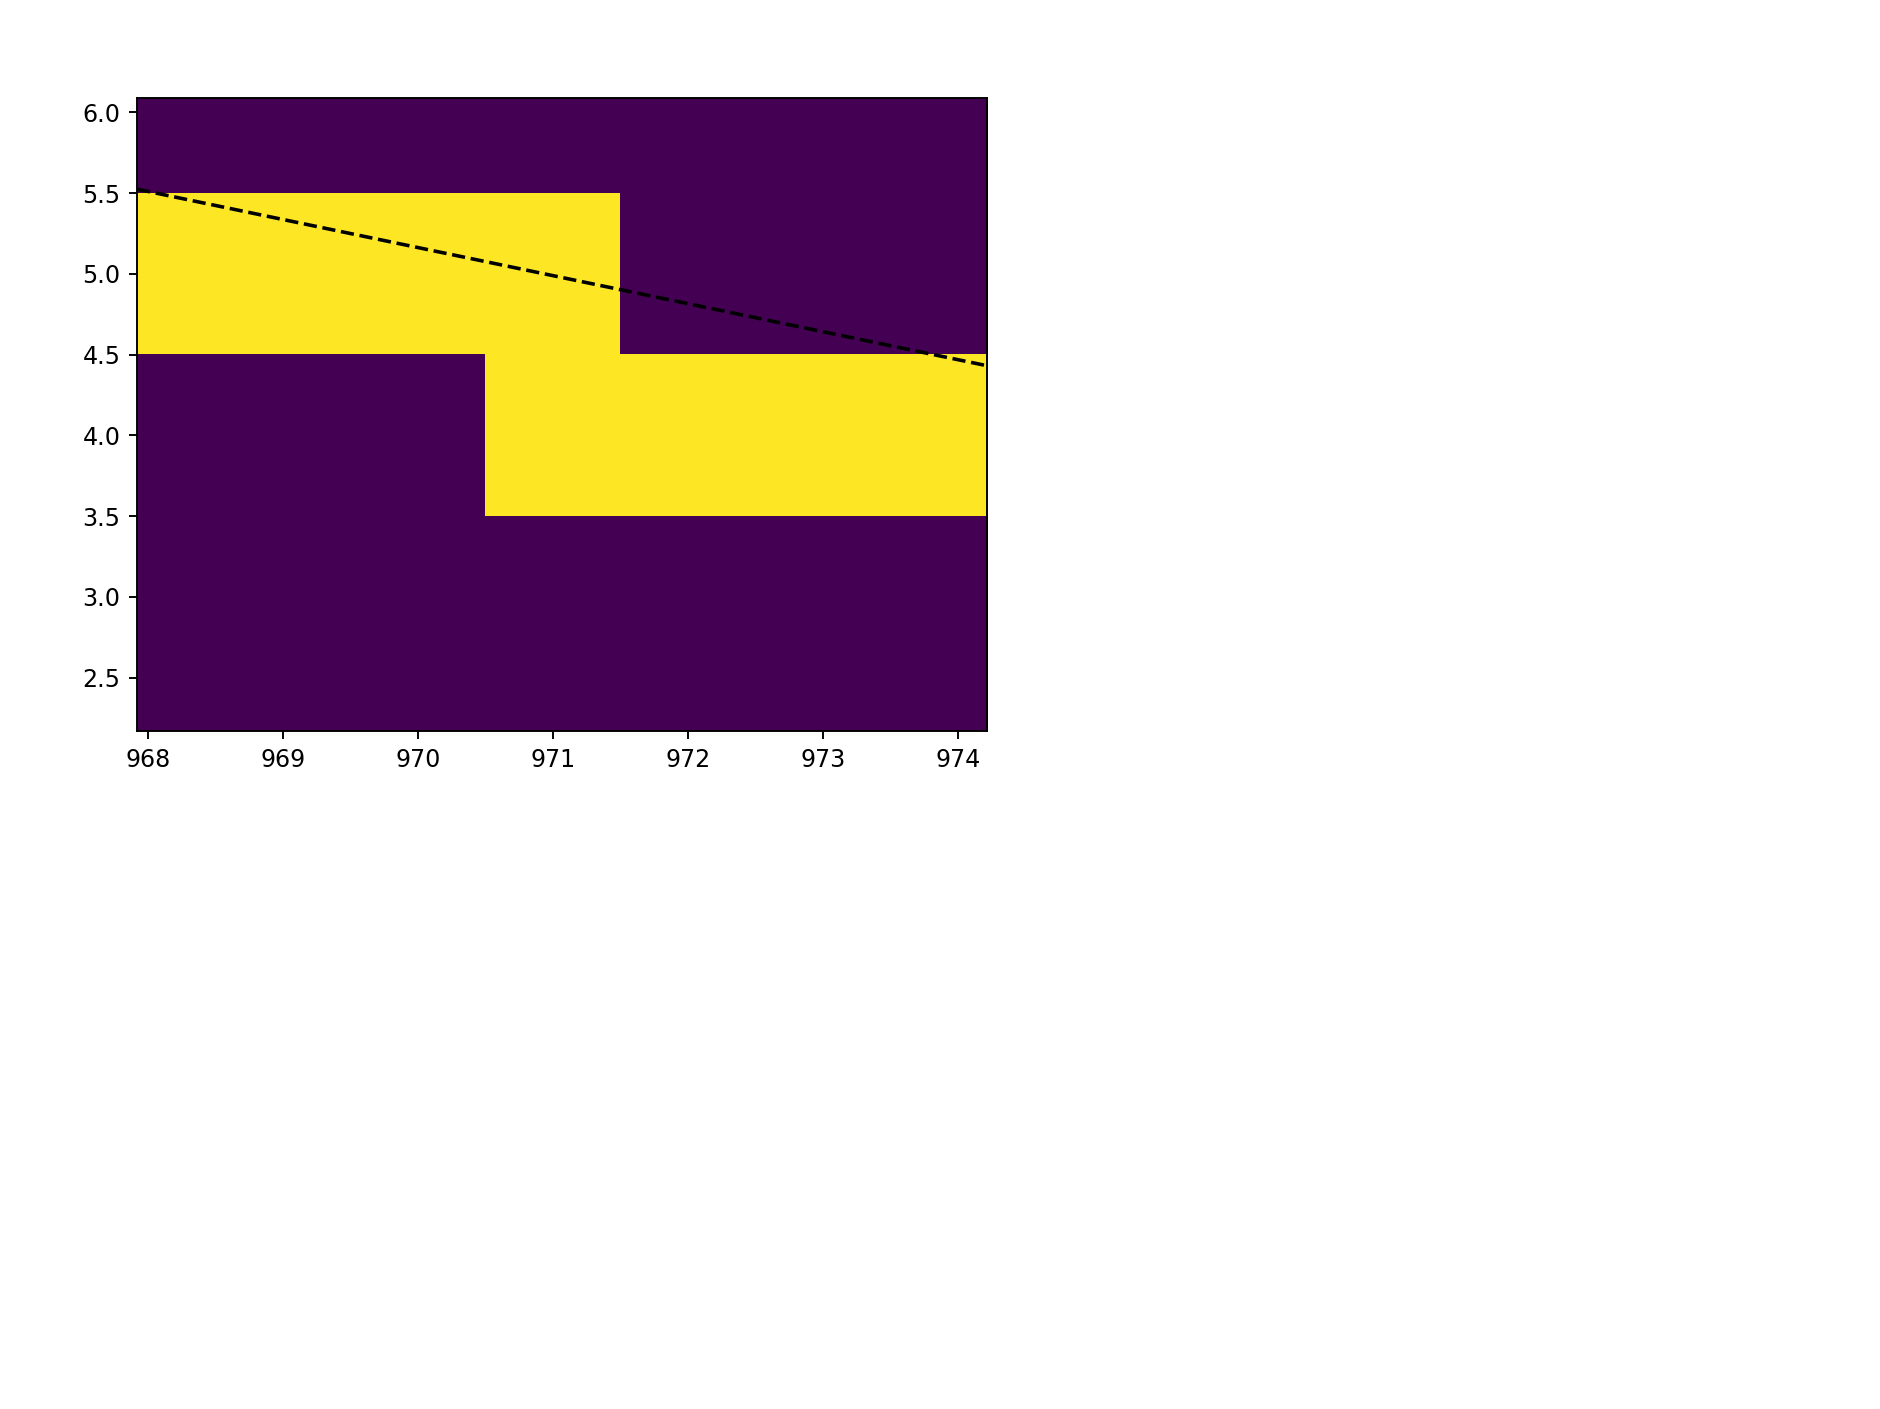

In [98]:
plt.figure()
plt.imshow(track, aspect='auto', interpolation='None', origin='lower')
plt.plot(ts-0.5, fs, 'k--')

# Trying out Barak's implemetation of FDMT

In [9]:
bz_fdmt = BZ_FDMT.FDMT(x.astype(np.int32),f_min = fchans[0] - chw_2 * 2, f_max = fchans[-1] - chw_2 * 2, maxDT = 100, dataType=np.int32) 

initialization ended
deltaT =  2
N_f =  128.0
input_dims (256, 2, 1024)
output_dims [128, 3, 1024]
deltaT =  3
N_f =  64.0
input_dims (128, 3, 1024)
output_dims [64, 4, 1024]
deltaT =  5
N_f =  32.0
input_dims (64, 4, 1024)
output_dims [32, 6, 1024]
deltaT =  10
N_f =  16.0
input_dims (32, 6, 1024)
output_dims [16, 11, 1024]
deltaT =  18
N_f =  8.0
input_dims (16, 11, 1024)
output_dims [8, 19, 1024]
deltaT =  34
N_f =  4.0
input_dims (8, 19, 1024)
output_dims [4, 35, 1024]
deltaT =  60
N_f =  2.0
input_dims (4, 35, 1024)
output_dims [2, 61, 1024]
deltaT =  99
N_f =  1.0
input_dims (2, 61, 1024)
output_dims [1, 100, 1024]
total_time: 0.03400850296020508


In [11]:
bz_fdmt.shape

(100, 1024)

<IPython.core.display.Javascript object>


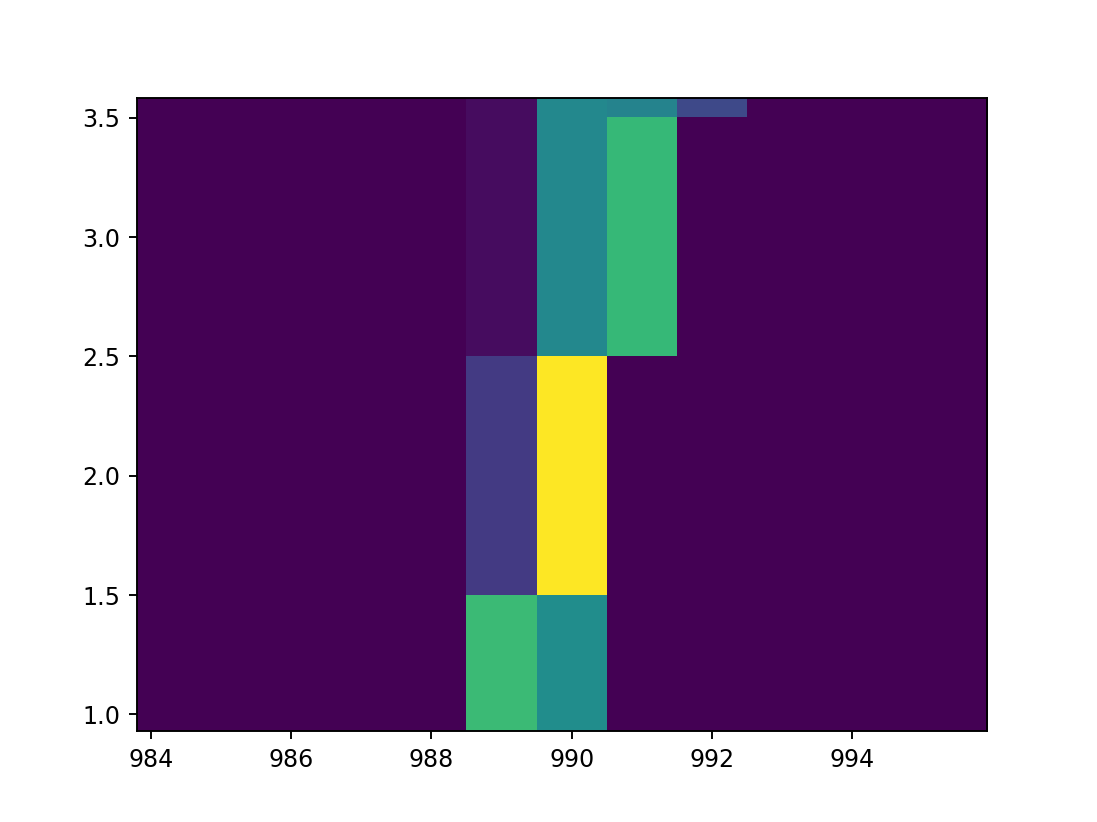

In [13]:
imshow(bz_fdmt)

In [14]:
np.max(bz_fdmt)

2189277

In [35]:
t1 = pd.read_csv("fdmt_performance_spp0.1.txt", sep="\s+")
t2 = pd.read_csv("fdmt_performance_with_bz_spp0.1.txt", sep="\s+")

<IPython.core.display.Javascript object>


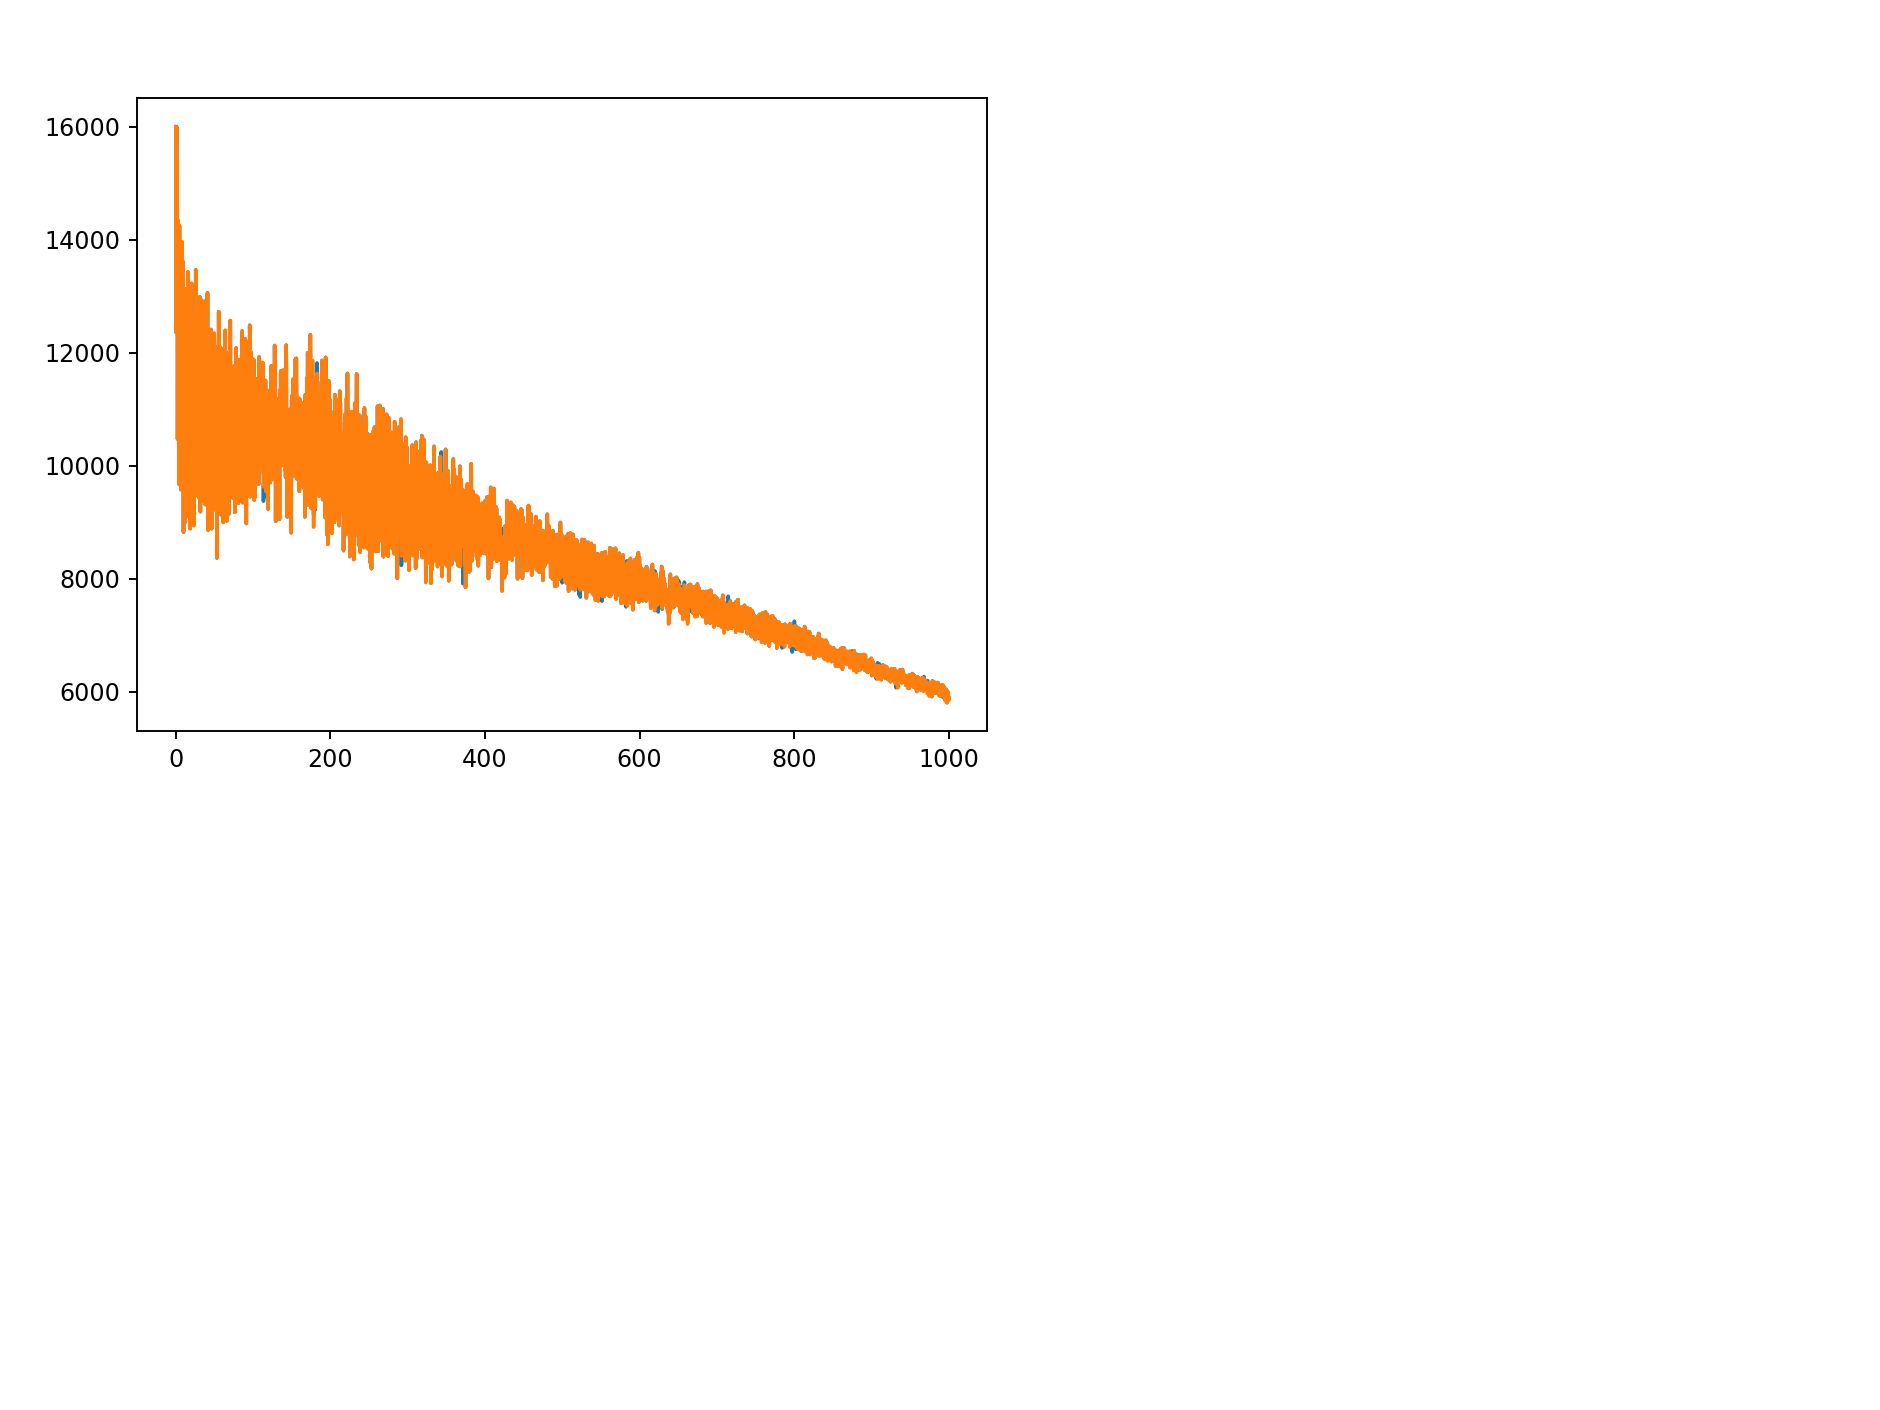

In [36]:

plt.figure()
plt.plot(t1['DM'], t1['FDMT_snr'])
plt.plot(t2['DM'], t2['BZ_FDMT_snr'])

In [91]:
import sys
sys.path.append("/home/gup037/Codes/ESAM/esam")
import esam, traces

In [92]:
tree = esam.EsamTree(nch)

In [97]:
nch = 256
fchans = np.linspace(800.5, 1055.5, nch, endpoint=True, dtype=np.float32)
chw_2 = 0.5
nsamps = 1024
tpulse = 990.1
dm = 22
tx = 100
x, tot_samps_added = make_pure_frb(nsamps, nch, tx, dm, fchans, chw_2, tpulse)


In [98]:
test_trace = traces.digitize_trace(traces.mask_to_trace(x))

In [99]:
test_trace

[[0, array([1., 1.], dtype=float32)],
 [0, array([1.], dtype=float32)],
 [0, array([1.], dtype=float32)],
 [0, array([1.], dtype=float32)],
 [0, array([1.], dtype=float32)],
 [0, array([1.], dtype=float32)],
 [0, array([1.], dtype=float32)],
 [0, array([1.], dtype=float32)],
 [-1, array([1., 1.], dtype=float32)],
 [0, array([1.], dtype=float32)],
 [0, array([1.], dtype=float32)],
 [0, array([1.], dtype=float32)],
 [0, array([1.], dtype=float32)],
 [0, array([1.], dtype=float32)],
 [0, array([1.], dtype=float32)],
 [0, array([1.], dtype=float32)],
 [-1, array([1., 1.], dtype=float32)],
 [0, array([1.], dtype=float32)],
 [0, array([1.], dtype=float32)],
 [0, array([1.], dtype=float32)],
 [0, array([1.], dtype=float32)],
 [0, array([1.], dtype=float32)],
 [0, array([1.], dtype=float32)],
 [0, array([1.], dtype=float32)],
 [0, array([1.], dtype=float32)],
 [-1, array([1., 1.], dtype=float32)],
 [0, array([1.], dtype=float32)],
 [0, array([1.], dtype=float32)],
 [0, array([1.], dtype=float3

In [100]:
tree.get_trace_pid(test_trace)

1

In [101]:
tree.total_products


683

In [73]:
tree.descriptor_tree

<bound method EsamTree.descriptor_tree of Nchan=256 chan=0 nprod=1>

In [83]:
tree.descriptor_tree()

[[Nchan=256 chan=0 nprod=2],
 [Nchan=128 chan=0 nprod=2, Nchan=128 chan=1 nprod=2],
 [Nchan=64 chan=0 nprod=2,
  Nchan=64 chan=1 nprod=2,
  Nchan=64 chan=2 nprod=2,
  Nchan=64 chan=3 nprod=2],
 [Nchan=32 chan=0 nprod=2,
  Nchan=32 chan=1 nprod=2,
  Nchan=32 chan=2 nprod=2,
  Nchan=32 chan=3 nprod=2,
  Nchan=32 chan=4 nprod=2,
  Nchan=32 chan=5 nprod=2,
  Nchan=32 chan=6 nprod=2,
  Nchan=32 chan=7 nprod=2],
 [Nchan=16 chan=0 nprod=2,
  Nchan=16 chan=1 nprod=2,
  Nchan=16 chan=2 nprod=2,
  Nchan=16 chan=3 nprod=2,
  Nchan=16 chan=4 nprod=2,
  Nchan=16 chan=5 nprod=2,
  Nchan=16 chan=6 nprod=2,
  Nchan=16 chan=7 nprod=2,
  Nchan=16 chan=8 nprod=2,
  Nchan=16 chan=9 nprod=2,
  Nchan=16 chan=10 nprod=2,
  Nchan=16 chan=11 nprod=2,
  Nchan=16 chan=12 nprod=2,
  Nchan=16 chan=13 nprod=2,
  Nchan=16 chan=14 nprod=2,
  Nchan=16 chan=15 nprod=2],
 [Nchan=8 chan=0 nprod=2,
  Nchan=8 chan=1 nprod=2,
  Nchan=8 chan=2 nprod=2,
  Nchan=8 chan=3 nprod=2,
  Nchan=8 chan=4 nprod=2,
  Nchan=8 chan=5 npro

In [105]:
tree.count_all_pids()

[297, 166, 99, 59, 32, 16, 8, 4, 2]

In [104]:
all_pids

[[EndProduct kernel=[1.],
  EndProduct kernel=[1.],
  EndProduct kernel=[1.],
  EndProduct kernel=[1.],
  EndProduct kernel=[1.],
  EndProduct kernel=[1.],
  EndProduct kernel=[1.],
  EndProduct kernel=[1.],
  EndProduct kernel=[1.],
  EndProduct kernel=[1.],
  EndProduct kernel=[1.],
  EndProduct kernel=[1.],
  EndProduct kernel=[1.],
  EndProduct kernel=[1.],
  EndProduct kernel=[1.],
  EndProduct kernel=[1.],
  EndProduct kernel=[1. 1.],
  EndProduct kernel=[1. 1.],
  EndProduct kernel=[1.],
  EndProduct kernel=[1.],
  EndProduct kernel=[1.],
  EndProduct kernel=[1.],
  EndProduct kernel=[1.],
  EndProduct kernel=[1.],
  EndProduct kernel=[1.],
  EndProduct kernel=[1.],
  EndProduct kernel=[1.],
  EndProduct kernel=[1.],
  EndProduct kernel=[1.],
  EndProduct kernel=[1.],
  EndProduct kernel=[1.],
  EndProduct kernel=[1.],
  EndProduct kernel=[1.],
  EndProduct kernel=[1.],
  EndProduct kernel=[1.],
  EndProduct kernel=[1. 1.],
  EndProduct kernel=[1. 1.],
  EndProduct kernel=[1.],


In [106]:
tt = esam.EsamTree(256)

In [107]:
tt.count_all_pids()

[0, 0, 0, 0, 0, 0, 0, 0, 0]

In [118]:
%timeit tn = np.ones(len(tt.count_all_pids())); tn[:] = tt.count_all_pids()

1.57 ms ± 15.6 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [117]:
tn

array([0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [119]:
np.savetxt?

In [127]:
product_counts = pd.read_csv("product_counts.txt", delimiter="\s", header=None)

/home/gup037/miniconda3/envs/craco/lib/python3.6/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [128]:
product_counts

,0,1,2,3,4,5,6,7,8
0,256.0,128.0,64.0,32.0,16.0,8.0,4.0,2.0,1.0
1,256.0,128.0,64.0,32.0,16.0,8.0,4.0,2.0,1.0
2,256.0,128.0,64.0,32.0,16.0,8.0,4.0,2.0,1.0
3,256.0,128.0,64.0,32.0,16.0,8.0,4.0,2.0,1.0
4,256.0,128.0,64.0,32.0,16.0,8.0,4.0,2.0,1.0
...,...,...,...,...,...,...,...,...,...
9995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [130]:
product_counts.keys()

Int64Index([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype='int64')

<IPython.core.display.Javascript object>


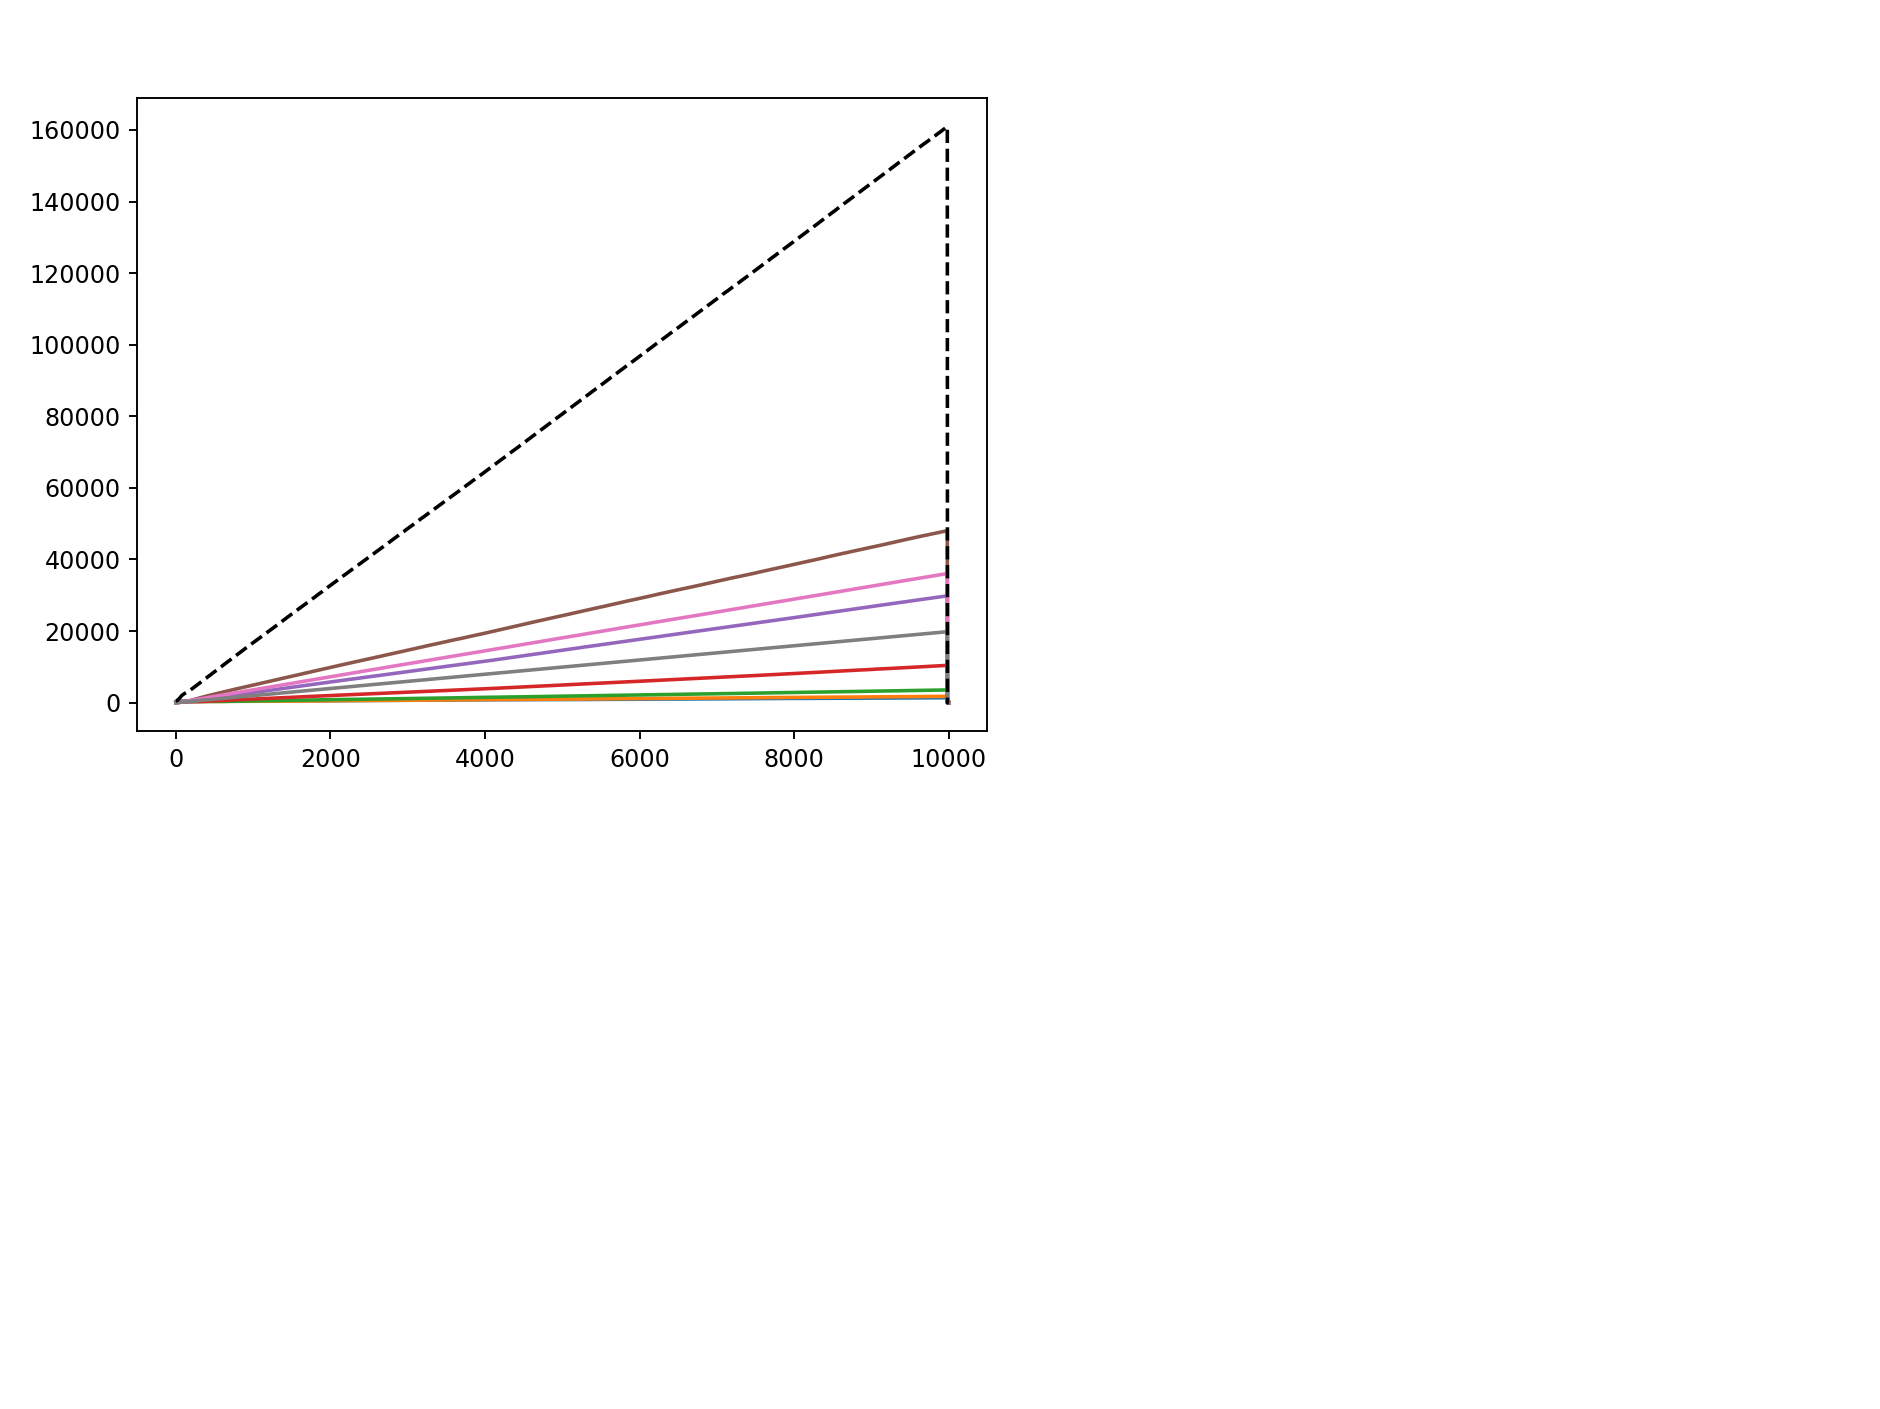

In [134]:
plt.figure()
for i in range(8):
    plt.plot(product_counts[i])
    
plt.plot(product_counts.sum(axis=1), 'k--')
plt.plot()

In [257]:
fdmt_product_counts = pd.read_csv("product_counts_fdmt_tracks_0_1000.txt", sep="\s", header = None)
esam_product_counts = pd.read_csv("product_counts_dm_0_1000_1.txt", sep="\s", header = None)

/home/gup037/miniconda3/envs/craco/lib/python3.6/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.
/home/gup037/miniconda3/envs/craco/lib/python3.6/site-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


In [258]:
fdmt_product_counts.shape

(1000, 9)

<IPython.core.display.Javascript object>


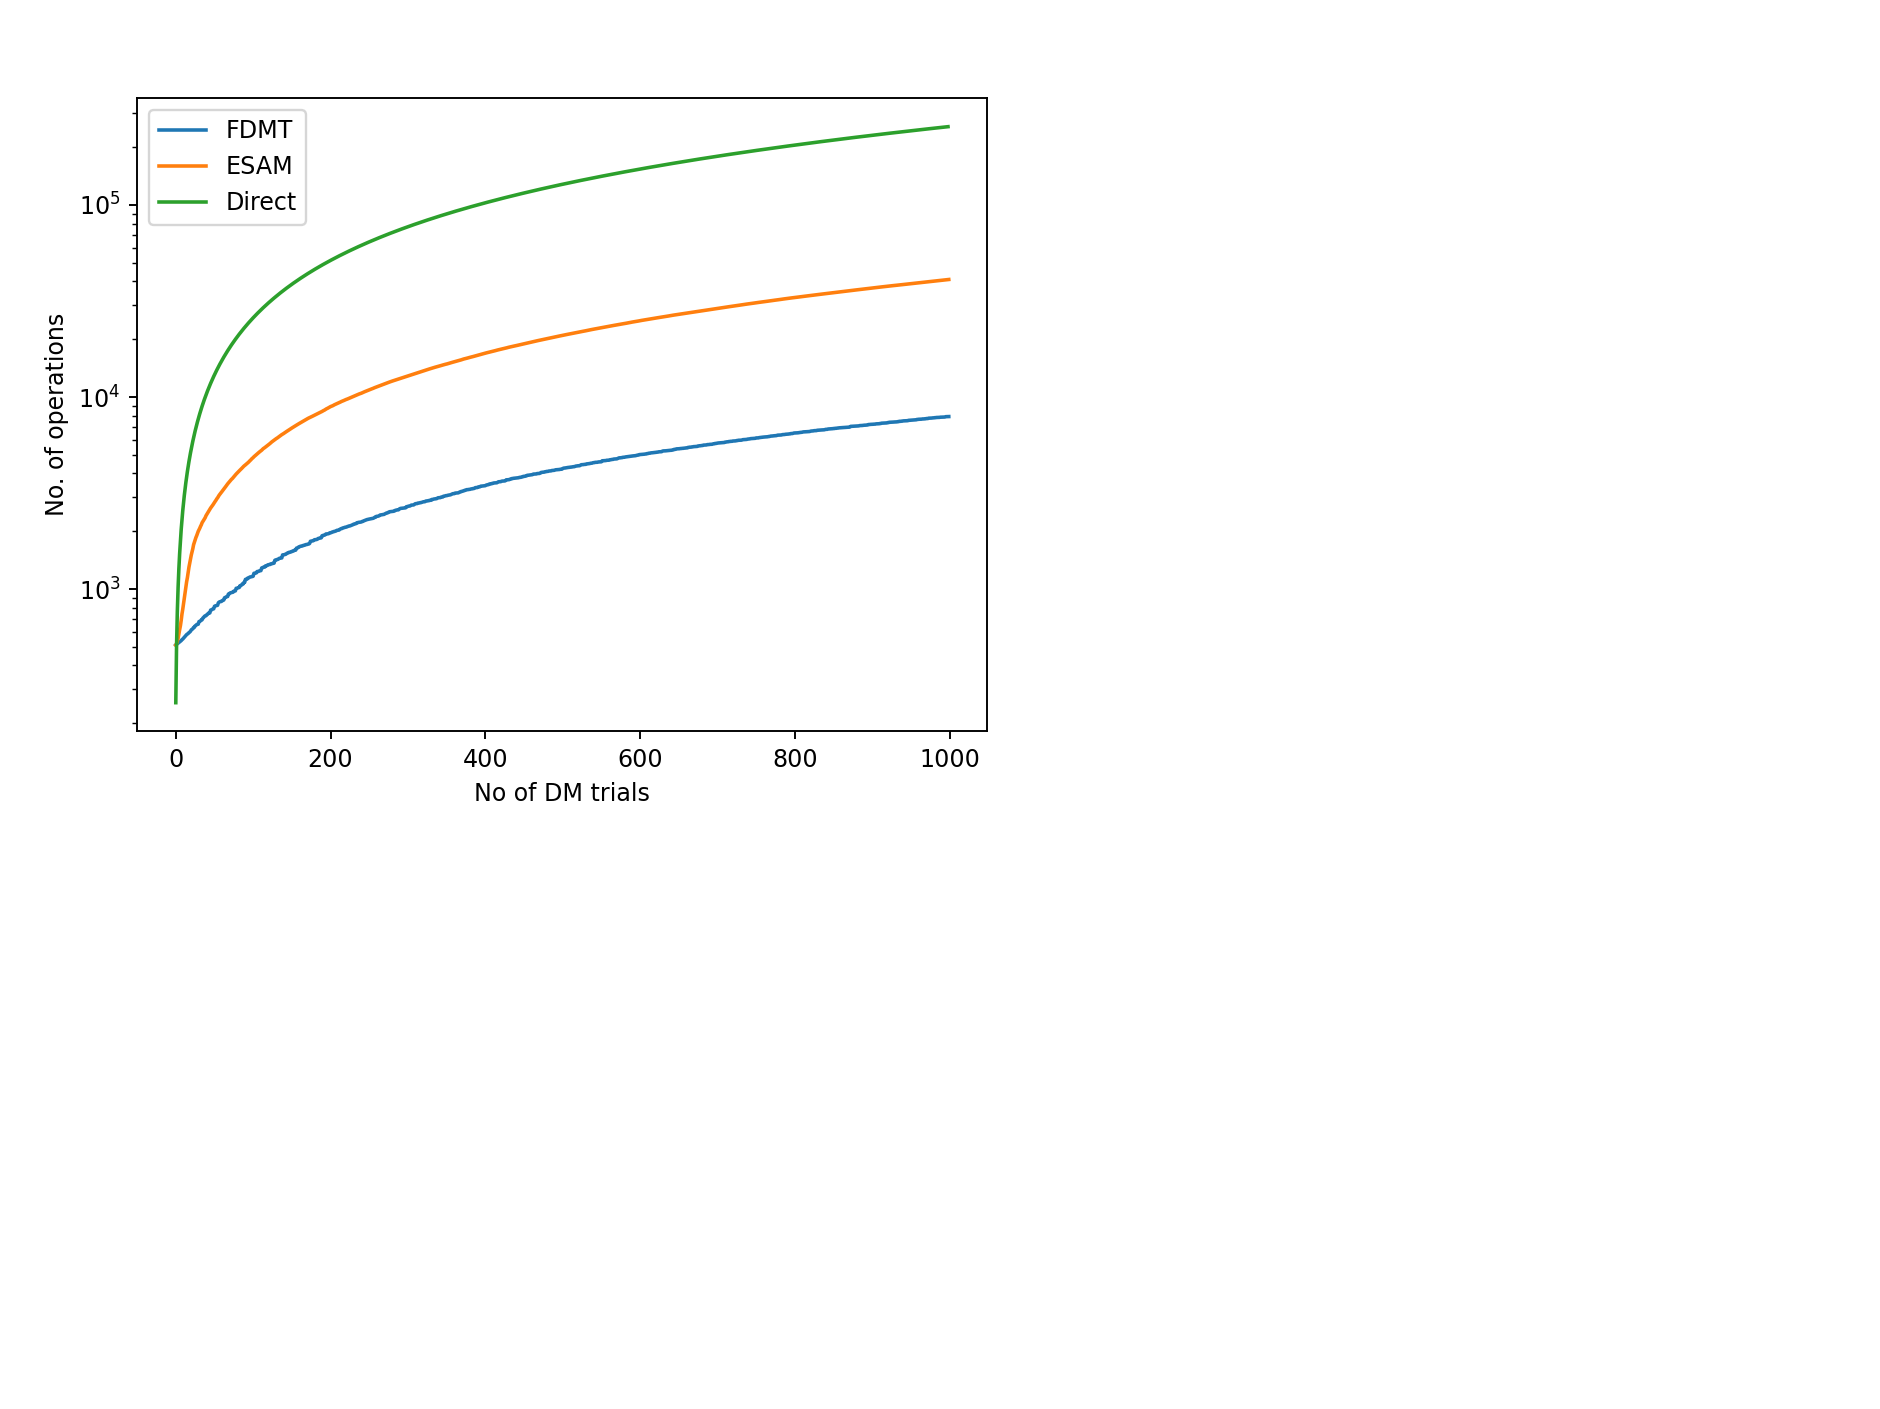

In [261]:
plt.figure()
#for i in range(8):
#    plt.plot(fdmt_product_counts[i])
    
plt.plot(fdmt_product_counts.sum(axis=1), label="FDMT")
plt.plot(esam_product_counts.sum(axis=1), label="ESAM")
plt.plot(nch * np.arange(1, fdmt_product_counts.shape[0]), label="Direct")
plt.yscale('log')
plt.xlabel("No of DM trials")
plt.ylabel("No. of operations")
plt.legend()

In [135]:
tree

Nchan=256 chan=0 nprod=2

In [137]:
np.save("test_pickle", tree)

In [139]:
loaded_pickle = np.load("test_pickle.npy", allow_pickle=True)

In [152]:
loaded_pickle.item() == tree

False

In [153]:
loaded_tree = loaded_pickle.item()

In [155]:
loaded_tree.descriptor_tree() == tree.descriptor_tree()

False

In [156]:
loaded_tree.count_all_pids()

[297, 166, 99, 59, 32, 16, 8, 4, 2]

In [157]:
tree.count_all_pids()

[297, 166, 99, 59, 32, 16, 8, 4, 2]

In [158]:
loaded_tree.get_all_pids()

[[EndProduct kernel=[1.],
  EndProduct kernel=[1.],
  EndProduct kernel=[1.],
  EndProduct kernel=[1.],
  EndProduct kernel=[1.],
  EndProduct kernel=[1.],
  EndProduct kernel=[1.],
  EndProduct kernel=[1.],
  EndProduct kernel=[1.],
  EndProduct kernel=[1.],
  EndProduct kernel=[1.],
  EndProduct kernel=[1.],
  EndProduct kernel=[1.],
  EndProduct kernel=[1.],
  EndProduct kernel=[1.],
  EndProduct kernel=[1.],
  EndProduct kernel=[1. 1.],
  EndProduct kernel=[1. 1.],
  EndProduct kernel=[1.],
  EndProduct kernel=[1.],
  EndProduct kernel=[1.],
  EndProduct kernel=[1.],
  EndProduct kernel=[1.],
  EndProduct kernel=[1.],
  EndProduct kernel=[1.],
  EndProduct kernel=[1.],
  EndProduct kernel=[1.],
  EndProduct kernel=[1.],
  EndProduct kernel=[1.],
  EndProduct kernel=[1.],
  EndProduct kernel=[1.],
  EndProduct kernel=[1.],
  EndProduct kernel=[1.],
  EndProduct kernel=[1.],
  EndProduct kernel=[1.],
  EndProduct kernel=[1. 1.],
  EndProduct kernel=[1. 1.],
  EndProduct kernel=[1.],


In [160]:
loaded_tree.get_all_pids() == tree.get_all_pids()

True

In [328]:
esam_fdmt_track_snrs = pd.read_csv("esam_snr_recovery_fdmt_tracks_only.txt", sep="\s+")

<IPython.core.display.Javascript object>


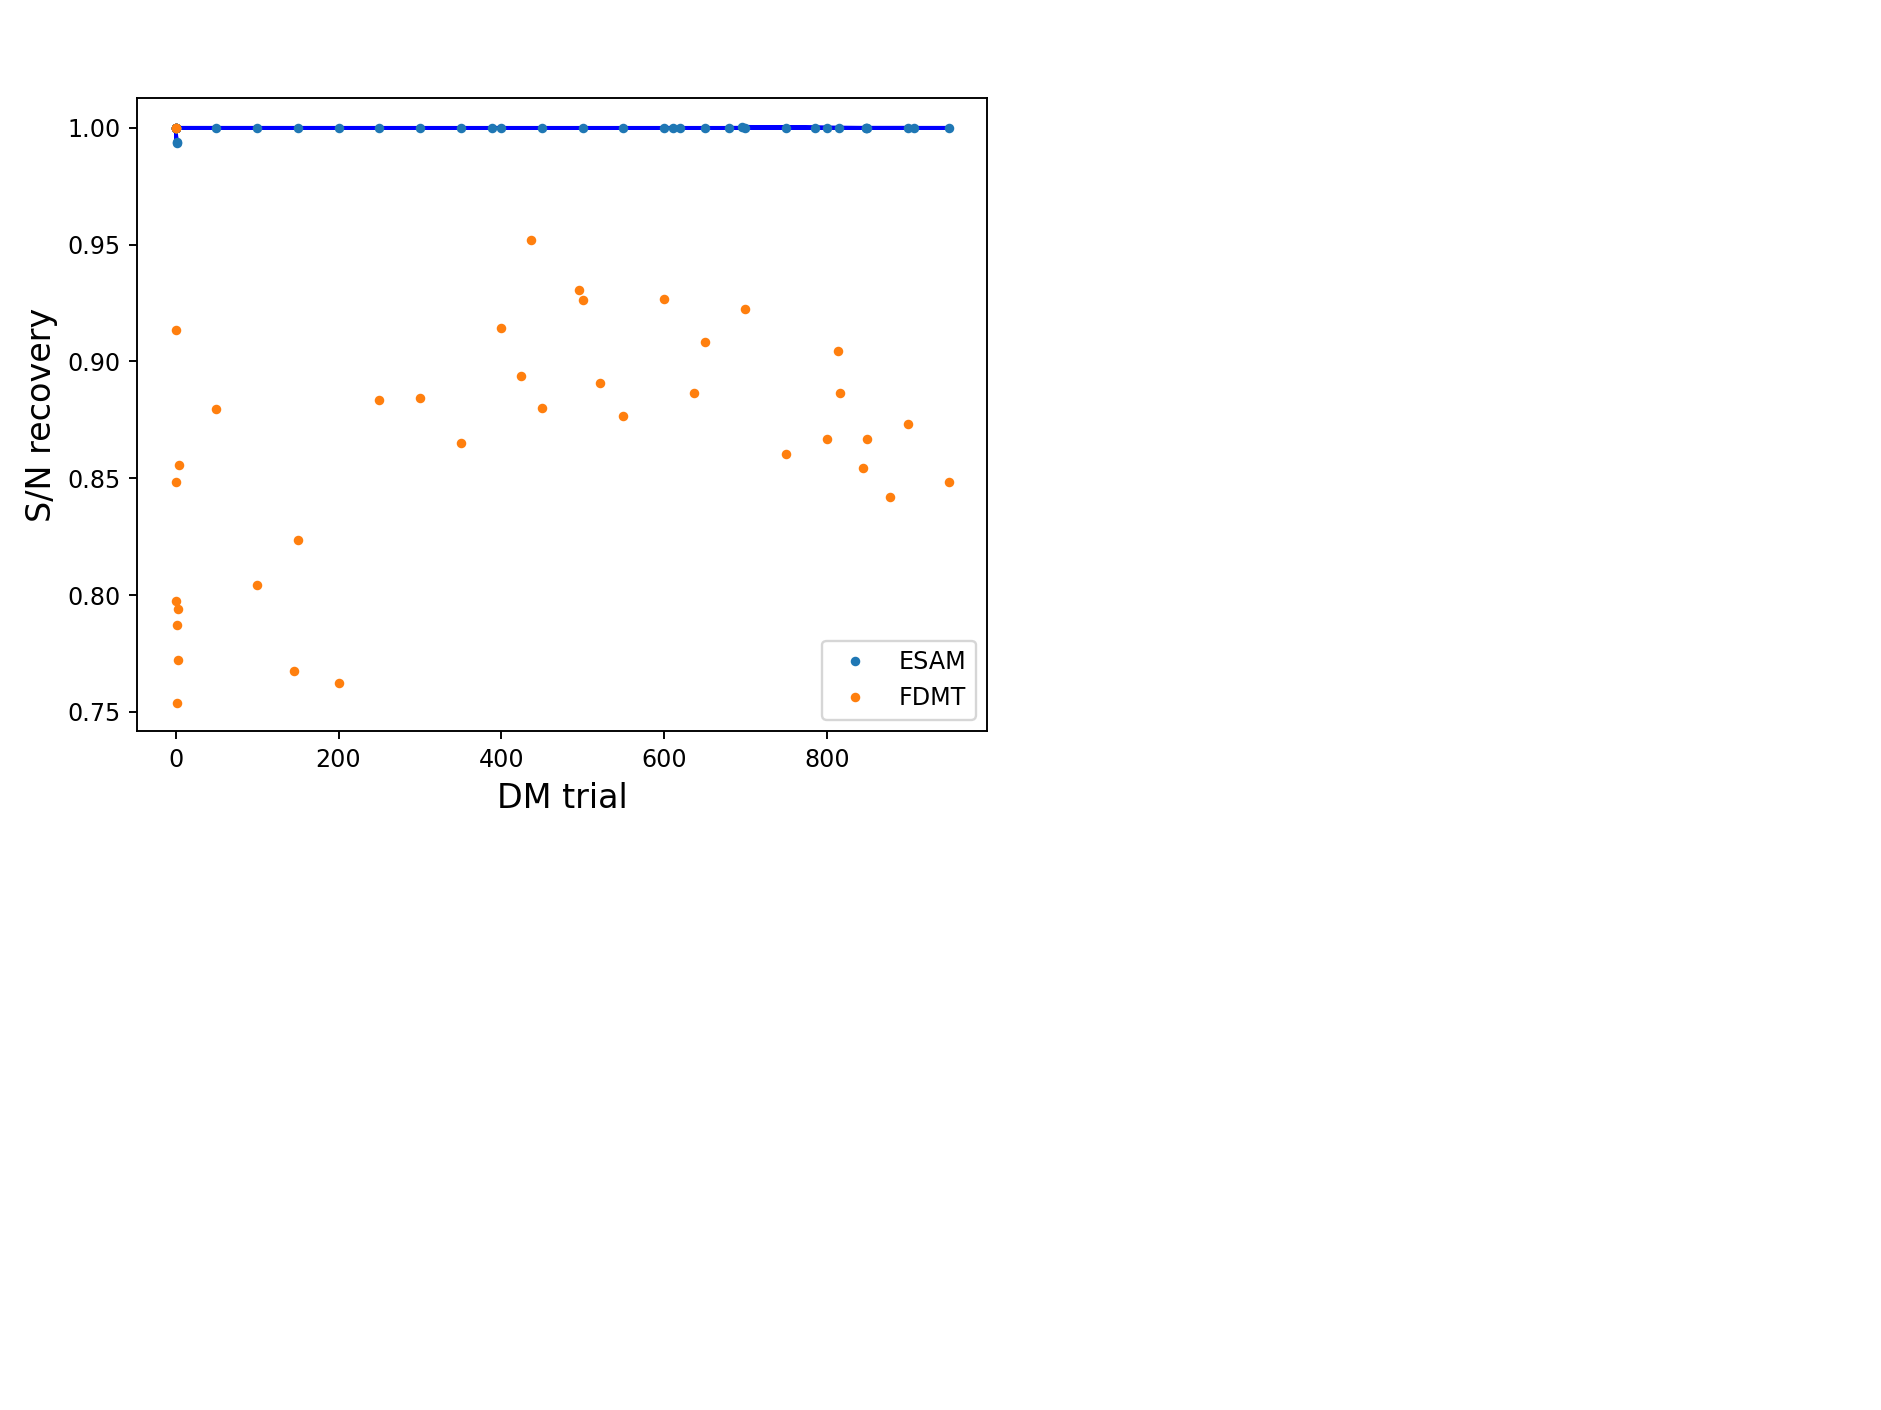

In [336]:
plt.figure()
sel = (esam_snrs['ESAM_snr'] / esam_snrs['Max_snr']) > 0.97

plt.plot(esam_snrs[sel]['DM'], esam_snrs[sel]['ESAM_snr'] / esam_snrs[sel]['Max_snr'], c='blue')

plt.plot(esam_snrs[sel]['DM'], esam_snrs[sel]['ESAM_snr'] / esam_snrs[sel]['Max_snr'], '.', label='ESAM')

plt.plot(esam_fdmt_track_snrs['DM'], esam_fdmt_track_snrs['ESAM_snr'] / esam_fdmt_track_snrs['Max_snr'], '.', label='FDMT')
plt.xlabel("DM trial", fontsize=14)
plt.ylabel("S/N recovery", fontsize = 14)
plt.legend()
#plt.ylim(0, 1.1)

In [204]:
tt = pd.read_csv("fdmt_performance_0_to_1000_1_with_spp_0_to_0.9_0.1.txt", sep="\s+", header=None)

In [205]:
tt.shape

(1000, 11)

<IPython.core.display.Javascript object>


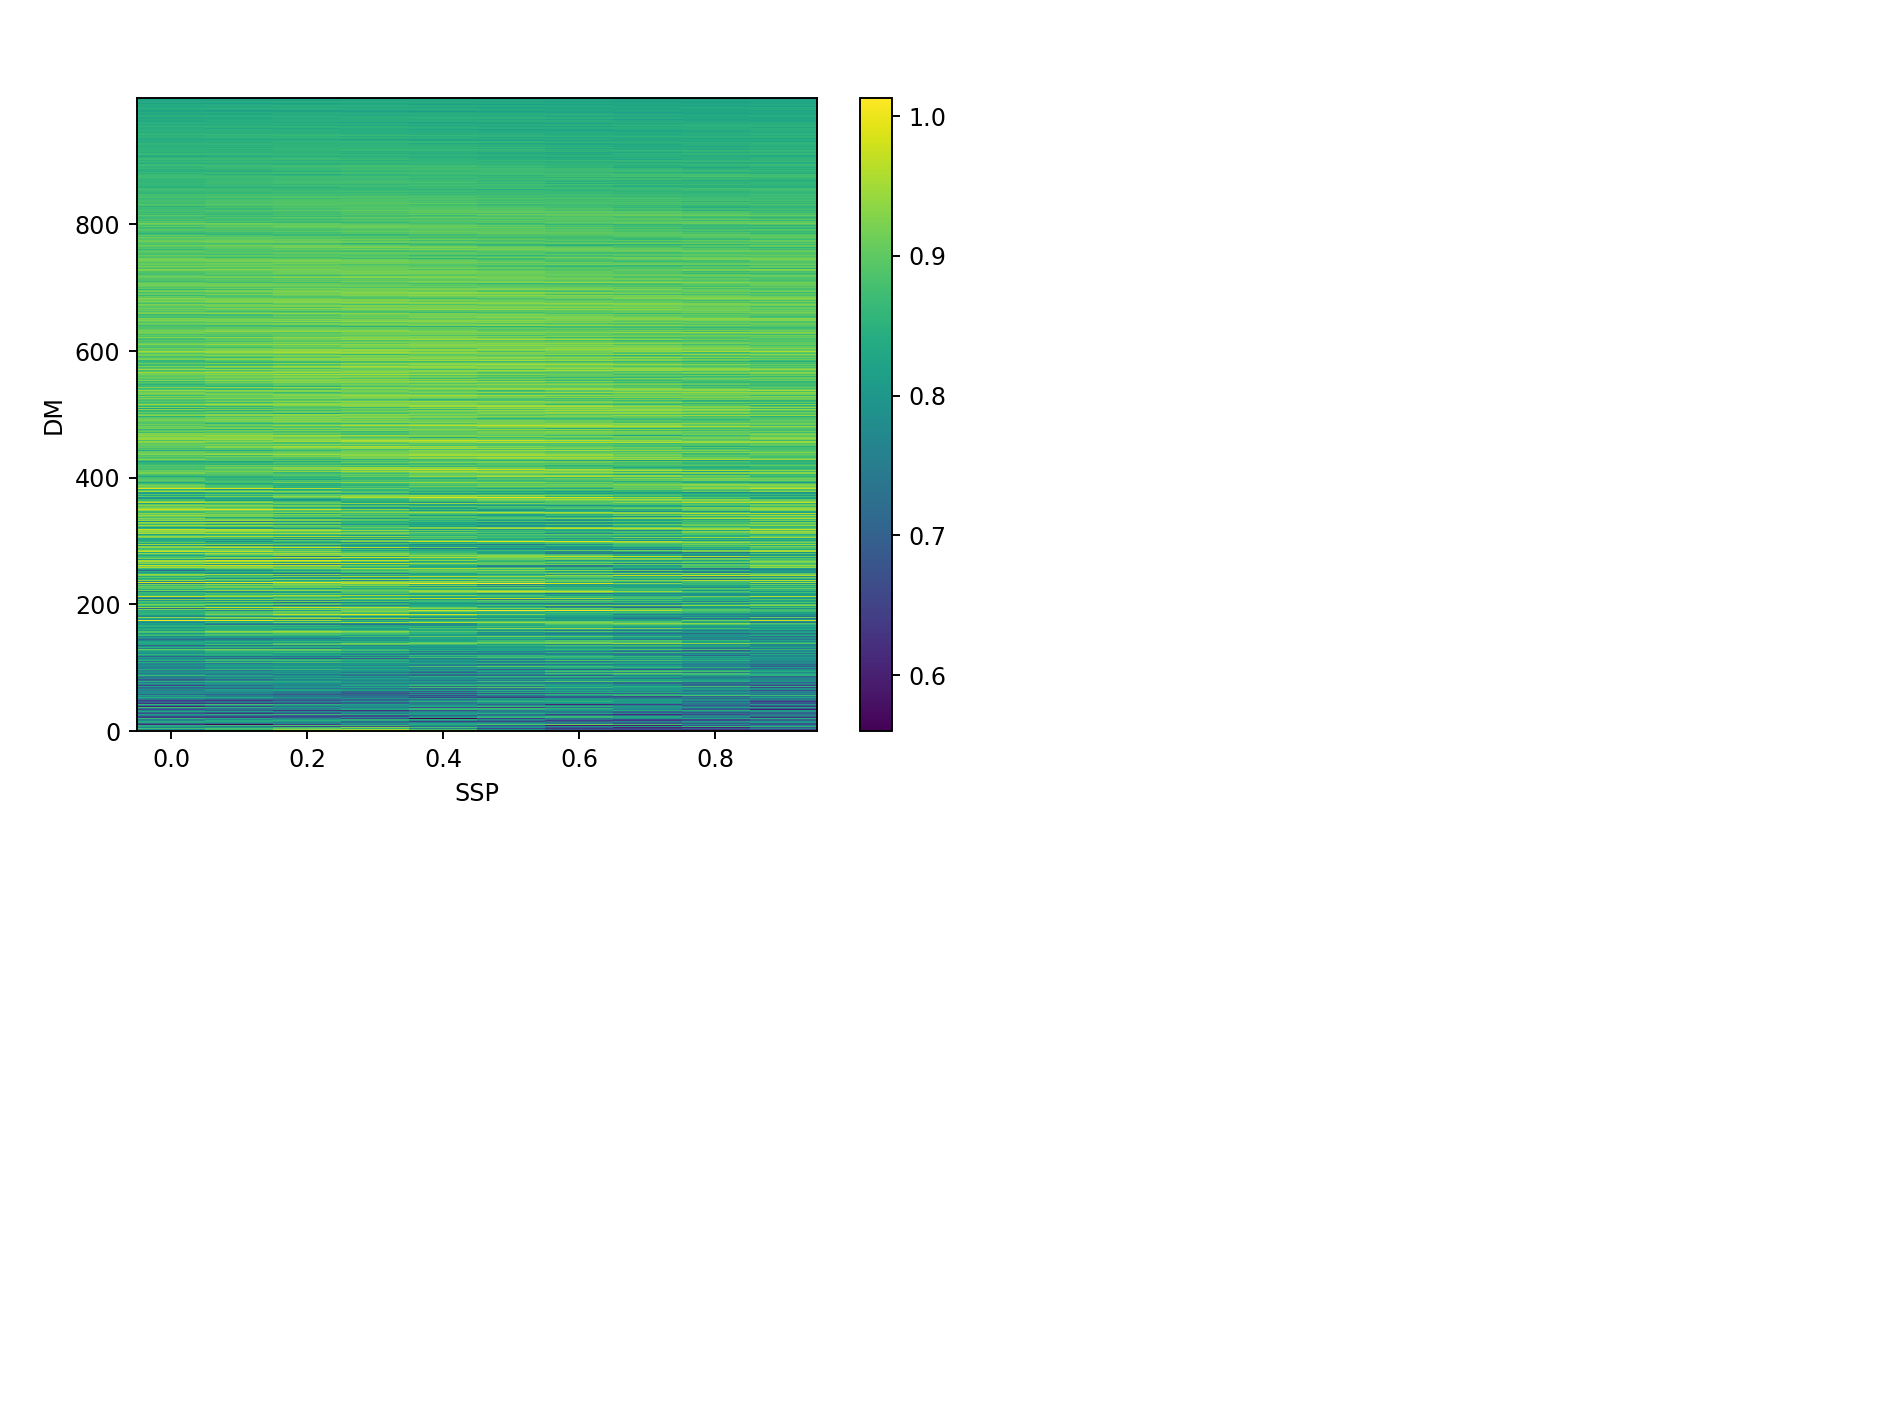

In [212]:
imshow(np.array(tt)[:, 1:], extent=[-0.05, 0.95, -0.5, 999.5])
plt.xlabel("SSP")
plt.ylabel("DM")
plt.colorbar()

In [267]:
nch = 256
fchans = np.linspace(400.5, 655.5, nch, endpoint=True, dtype=np.float32)
chw_2 = 0.5
nsamps = 512
tpulse = 510.5
dm = 500
tx = 10000
temp_x, tot_samps_added = make_pure_frb(nsamps, nch, tx, dm, fchans, chw_2, tpulse)
#%timeit make_pure_frb(nsamps, nch, tx, dm, fchans, chw_2, tpulse)


Text(56.75595238095237, 0.5, 'Frequency [channel no]')

<IPython.core.display.Javascript object>


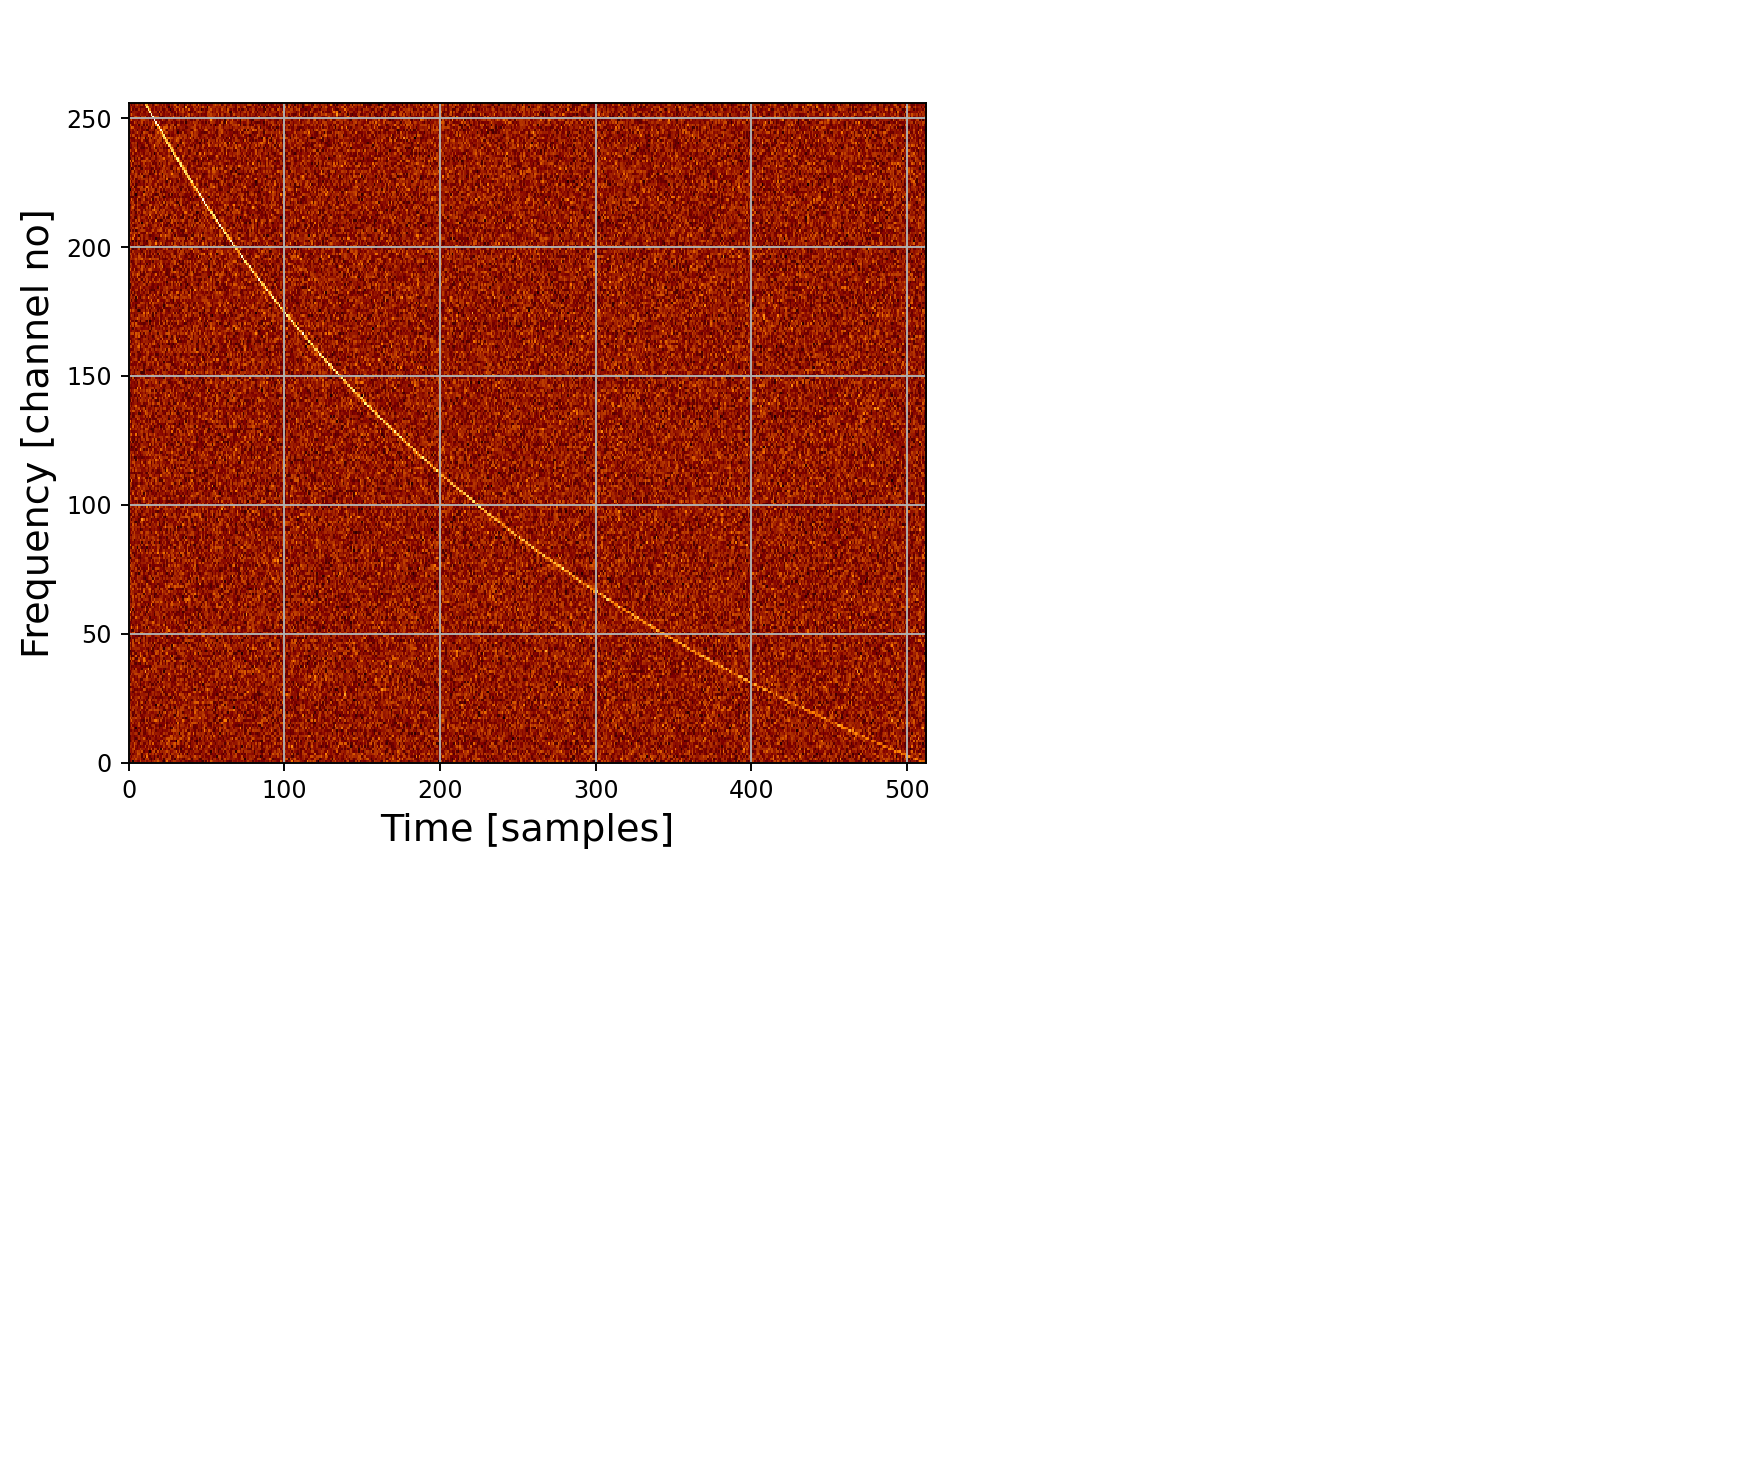

In [341]:

imshow(temp_x + np.random.normal(0, 1000, temp_x.size).reshape(temp_x.shape), cmap='afmhot', extent=[0, temp_x.shape[1], 0, temp_x.shape[0]])
plt.xlabel("Time [samples]", fontsize=16)
plt.ylabel("Frequency [channel no]", fontsize=16)
plt.grid()

In [295]:
plt.grid?

<IPython.core.display.Javascript object>


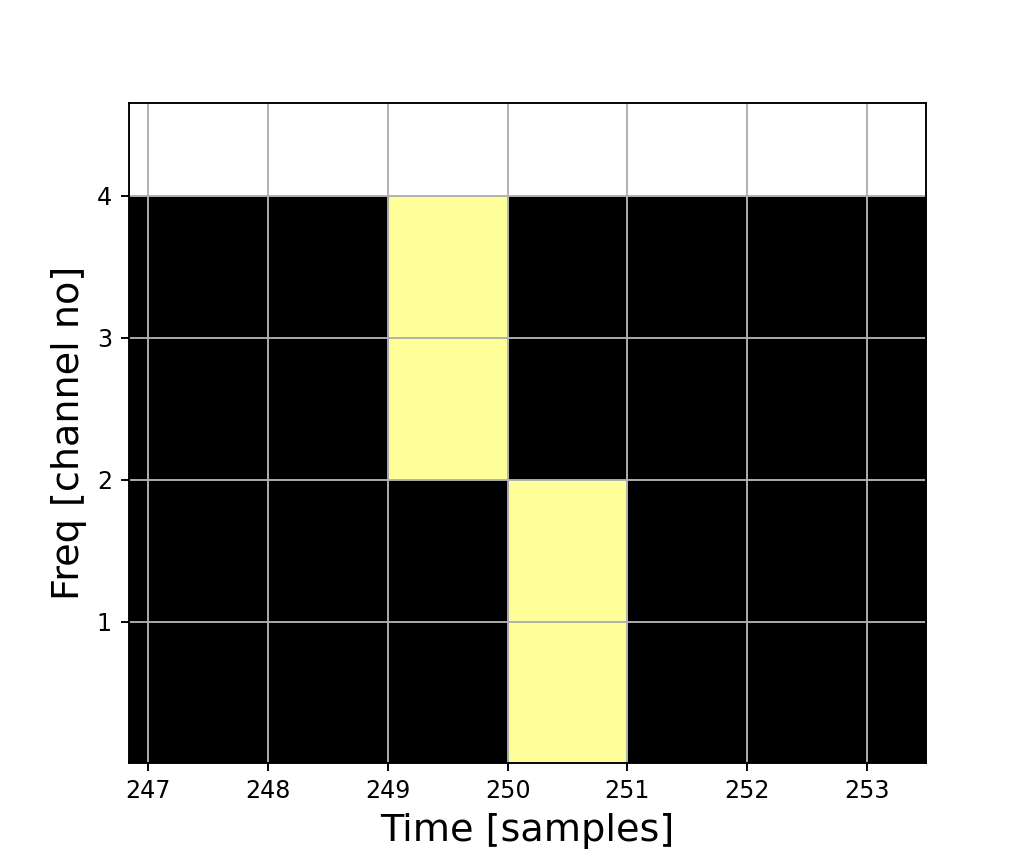

In [320]:
nch = 4
tt = np.zeros((nch, 512))
tt[:nch//2, 250] = np.linspace( 8, 8, nch//2)
tt[nch//2:, 249] = np.linspace(8, 8, nch//2)

tt[0, 0] = 10
#tt[:,251] = 0.3 * tt[:, 250]
#tt[:,249] = 0.7 * tt[:, 250]
imshow(tt, cmap='afmhot', extent=[0, 512, 0, 4])
plt.xlabel("Time [samples]", fontsize = 16)
plt.ylabel("Freq [channel no]", fontsize = 16)
plt.xlim(245, 255)
plt.grid()

<IPython.core.display.Javascript object>


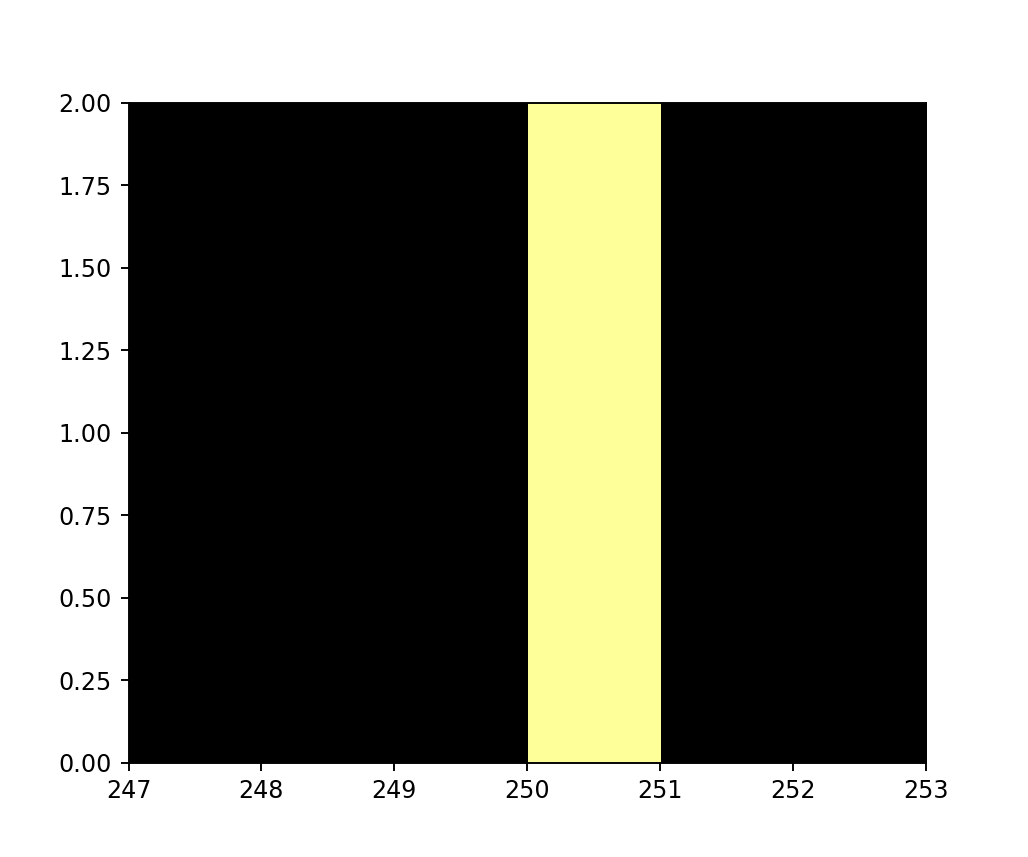

(247.0, 253.0)

In [323]:
imshow(tt[:nch//2], cmap='afmhot', extent=[0, 512, 0, 2])
plt.xlim(247, 253)